In [ ]:
!pip install sentence-transformers
from IPython.display import clear_output
clear_output()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
#import gensim
#from gensim.models import Word2Vec
import re
from nltk.tokenize import word_tokenize
import nltk
import os
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/dataset/Gemini output 1 with postprocessing.csv')

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/dataset/Gemini output 2 with postprocessing.csv')

In [ ]:
df_truth = pd.read_csv('/content/drive/MyDrive/dataset/manually_coded.csv')

In [ ]:
# Compare dataframes and count the number of differing cells
comparison_df = df1 != df2
diff_count = comparison_df.sum().sum()

# Display the count of differing cells
print("Number of differing cells:", diff_count)
total_cells = df1.size
print("Total number of cells:", total_cells)
print("% cells that are different: ", (diff_count/total_cells)*100, "%")

Number of differing cells: 2604
Total number of cells: 5643
% cells that are different:  46.14566719829878 %


In [ ]:
# Assuming the columns for title and body are 'Title' and 'Body'
title_column = 'Title'

# Sample dataframes (df1, df2, df_truth)
# Aligning the dataframes based on title and body

# Merge df1 and df_truth to find mismatches
merged_1 = pd.merge(df1[[title_column]], df_truth[[title_column]], on=[title_column], how='right', indicator=True)
extra_in_truth_1 = merged_1[merged_1['_merge'] == 'right_only']

# Merge df2 and df_truth to find mismatches
merged_2 = pd.merge(df2[[title_column]], df_truth[[title_column]], on=[title_column], how='right', indicator=True)
extra_in_truth_2 = merged_2[merged_2['_merge'] == 'right_only']

# Combine the mismatches to find the extra row in ground truth
extra_in_truth = pd.concat([extra_in_truth_1, extra_in_truth_2]).drop_duplicates()

# Display the extra row(s) in the ground truth dataframe
print("Extra row(s) in ground truth dataframe:")
print(extra_in_truth)

Extra row(s) in ground truth dataframe:
Empty DataFrame
Columns: [Title, _merge]
Index: []


In [ ]:
columns_to_check = ['Hero', 'Villain', 'Victim', 'Beneficiary', 'Ally', 'Opponent', 'Ineffective', 'Setting', 'Plot', 'Moral', 'Belief System', 'Narrative Strategy']

results_coder1 = {}
results_coder2 = {}
results_coders = {}

for column in columns_to_check:
    # Extract labels for each column from the three DataFrames
    labels_coder1 = df1[column].astype(str)
    labels_coder2 = df2[column].astype(str)
    labels_truth = df_truth[column].astype(str)

    # Calculate metrics for coder1 compared to truth
    accuracy1 = accuracy_score(labels_truth, labels_coder1)
    precision1 = precision_score(labels_truth, labels_coder1, average='macro', zero_division=0)
    recall1 = recall_score(labels_truth, labels_coder1, average='macro', zero_division=0)
    f1_1 = f1_score(labels_truth, labels_coder1, average='macro', zero_division=0)

    # Store results for coder1 in a dictionary
    results_coder1[column] = {
        'Accuracy': accuracy1,
        'Precision': precision1,
        'Recall': recall1,
        'F1 Score': f1_1
    }

    # Calculate metrics for coder2 compared to truth
    accuracy2 = accuracy_score(labels_truth, labels_coder2)
    precision2 = precision_score(labels_truth, labels_coder2, average='macro', zero_division=0)
    recall2 = recall_score(labels_truth, labels_coder2, average='macro', zero_division=0)
    f1_2 = f1_score(labels_truth, labels_coder2, average='macro', zero_division=0)

    # Store results for coder2 in a dictionary
    results_coder2[column] = {
        'Accuracy': accuracy2,
        'Precision': precision2,
        'Recall': recall2,
        'F1 Score': f1_2
    }

    # Calculate metrics for coder2 compared to coder 1
    accuracy3 = accuracy_score(labels_coder1, labels_coder2)
    precision3 = precision_score(labels_coder1, labels_coder2, average='macro', zero_division=0)
    recall3 = recall_score(labels_coder1, labels_coder2, average='macro', zero_division=0)
    f1_3 = f1_score(labels_coder1, labels_coder2, average='macro', zero_division=0)

    # Store results for coder2 in a dictionary
    results_coders[column] = {
        'Accuracy': accuracy3,
        'Precision': precision3,
        'Recall': recall3,
        'F1 Score': f1_3
    }

# Convert results to DataFrames
results_df_coder1 = pd.DataFrame(results_coder1).T
results_df_coder2 = pd.DataFrame(results_coder2).T
results_coders = pd.DataFrame(results_coders).T

In [ ]:
# Display the results
print("Results for Coder 1:")
print(results_df_coder1.head(12))
print("\nResults for Coder 2:")
print(results_df_coder2.head(12))
print("\nResults for Coders 1 and 2:")
print(results_coders.head(12))

Results for Coder 1:
                    Accuracy  Precision    Recall  F1 Score
Hero                0.053872   0.026544  0.025483  0.024968
Villain             0.030303   0.018072  0.014992  0.015249
Victim              0.013468   0.011730  0.008814  0.008830
Beneficiary         0.013468   0.007326  0.003706  0.003748
Ally                0.030303   0.017886  0.019535  0.017930
Opponent            0.060606   0.006536  0.000454  0.000849
Ineffective         0.057239   0.017809  0.009708  0.010180
Setting             0.040404   0.027135  0.018841  0.020713
Plot                0.245791   0.230632  0.145902  0.120189
Moral               0.558923   0.462553  0.400467  0.345912
Belief System       0.350168   0.236790  0.207539  0.149685
Narrative Strategy  0.454545   0.090569  0.089895  0.078231

Results for Coder 2:
                    Accuracy  Precision    Recall  F1 Score
Hero                0.060606   0.027896  0.024784  0.024642
Villain             0.037037   0.017195  0.015228  0.0153

For similarity measures in characters -

In [ ]:
df = df_truth.copy()

In [ ]:
#@title Sentence Transformers

# Initialize the sentence transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# List of columns to compare
columns_to_compare = ['Hero', 'Villain', 'Victim', 'Beneficiary', 'Ally', 'Opponent', 'Ineffective', 'Setting']

# Function to embed and calculate cosine similarity
def embed_and_calculate_similarity(df1, df2, column):
    # Handle missing values by replacing them with an empty string
    df1[column] = df1[column].fillna('').astype(str)
    df2[column] = df2[column].fillna('').astype(str)

    df1[f'{column}_vector'] = df1[column].apply(lambda x: model.encode(x))
    df2[f'{column}_vector'] = df2[column].apply(lambda x: model.encode(x))

    similarity_matrix = cosine_similarity(np.stack(df1[f'{column}_vector'].values), np.stack(df2[f'{column}_vector'].values))
    similarity_df = pd.DataFrame(similarity_matrix, index=df1[column], columns=df2[column])
    return similarity_df

# Dictionary to store similarity dataframes
similarity_matrices = {}

# Calculate similarities for each column
#for col in columns_to_compare:
#    similarity_matrices[col] = embed_and_calculate_similarity(col)

# Visualize the results using heatmaps
#fig, axes = plt.subplots(len(columns_to_compare), 1, figsize=(10, 5 * len(columns_to_compare)))
#for ax, col in zip(axes, columns_to_compare):
#    sns.heatmap(similarity_matrices[col], annot=True, cmap='coolwarm', ax=ax)
#    ax.set_title(f'Cosine Similarity for {col}')

#plt.tight_layout()
#plt.show()


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

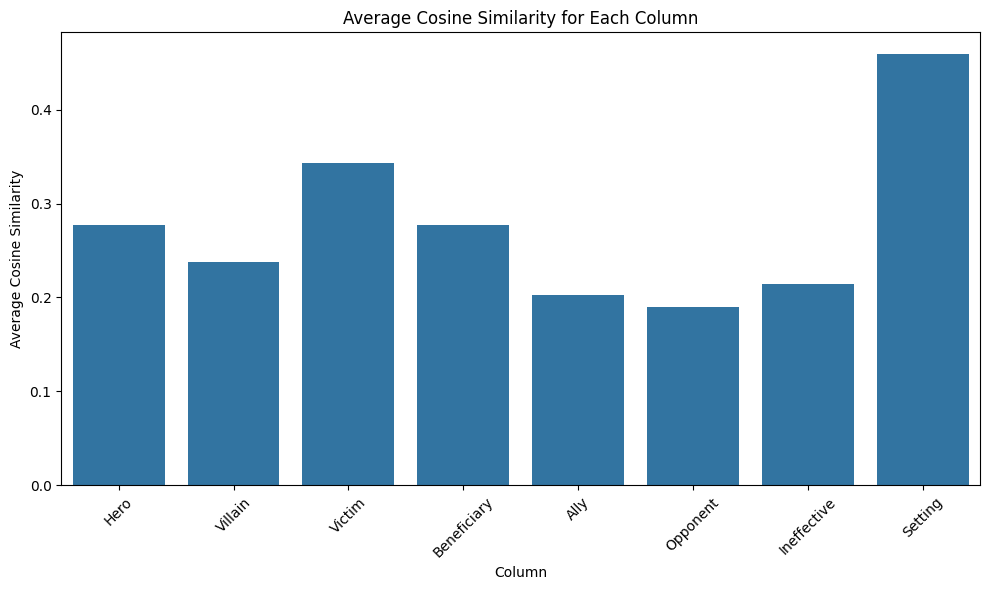

In [ ]:
# Dictionary to store average similarities
average_similarities = {}

# Calculate average similarities for each column
for col in columns_to_compare:
    similarity_matrix = embed_and_calculate_similarity(df1, df2, col)
    average_similarities[col] = np.mean(similarity_matrix)

# Create a DataFrame to hold the average similarities
average_similarities_df = pd.DataFrame(list(average_similarities.items()), columns=['Column', 'Average Cosine Similarity'])

# Visualize the results using a bar chart
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Column', y='Average Cosine Similarity', data=average_similarities_df)
plt.title('Average Cosine Similarity for Each Column')
plt.xlabel('Column')
plt.ylabel('Average Cosine Similarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

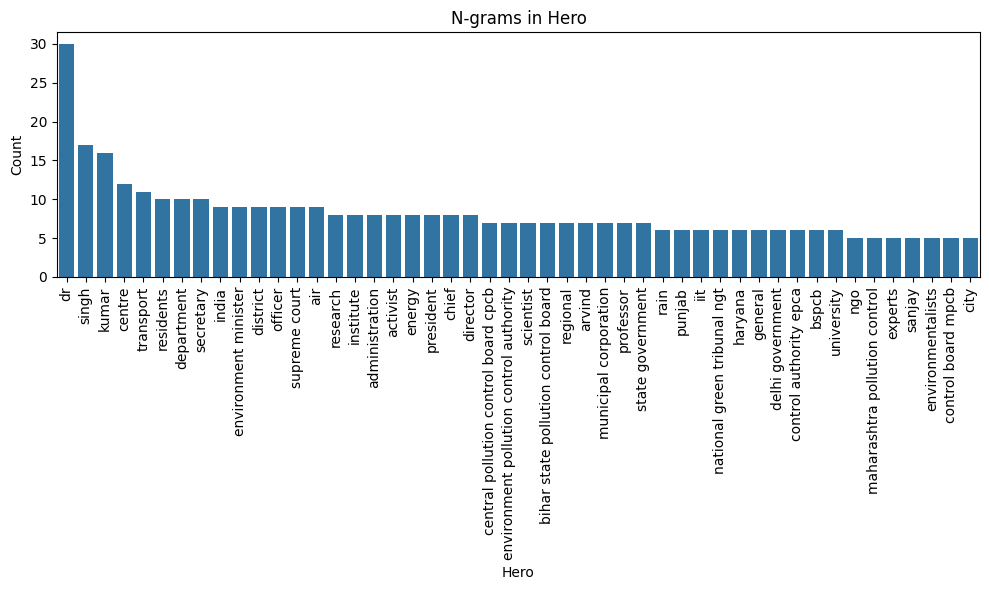

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 5), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

def remove_subsets(ngrams):
    to_remove = set()
    for i in range(len(ngrams)):
        for j in range(len(ngrams)):
            if i != j and ngrams[i][0] in ngrams[j][0]:
                to_remove.add(ngrams[i])
                break
    return [item for item in ngrams if item not in to_remove]

common_words = get_top_n_words(df_truth['Hero'], 100)
filtered_words = remove_subsets(common_words)
df_counts = pd.DataFrame(filtered_words, columns=['Hero', 'count'])

df_counts_grouped = df_counts.groupby('Hero').sum()['count'].sort_values(ascending=False)

# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=df_counts_grouped.index, y=df_counts_grouped.values)
plt.title('N-grams in Hero')
plt.xlabel('Hero')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import pandas as pd
import re

columns_to_check = ['Hero', 'Villain', 'Victim', 'Beneficiary', 'Ally', 'Opponent', 'Ineffective', 'Setting', 'Plot', 'Moral', 'Belief System', 'Narrative Strategy']

# Define a function to replace the text case-insensitively and count changes
def replace_none_explicitly_mentioned_and_count(df, columns):
    change_counter = 0

    def replace_none_explicitly_mentioned(cell):
        nonlocal change_counter
        cell_str = str(cell)  # Ensure the cell is treated as a string
        # Regex pattern to match variations of "None explicitly mentioned" and "Not explicitly mentioned" and "implied"
        pattern = re.compile(r'(none\s*explicitly\s*mentioned|not\s*explicitly\s*mentioned|no\s*explicitly\s*mentioned|\s*implied)', re.IGNORECASE)
        if pattern.search(cell_str):
            change_counter += 1
            return '0'
        return cell

    df[columns] = df[columns].applymap(replace_none_explicitly_mentioned)
    return df, change_counter

# Apply the function to the DataFrame and get the change count
df1, change_counter = replace_none_explicitly_mentioned_and_count(df1, columns_to_check)
df2, change_counter2 = replace_none_explicitly_mentioned_and_count(df2, columns_to_check)
# Print the number of changes made
print(f"Number of changes made: {change_counter}")
print(f"Number of changes made: {change_counter2}")

Number of changes made: 457
Number of changes made: 104


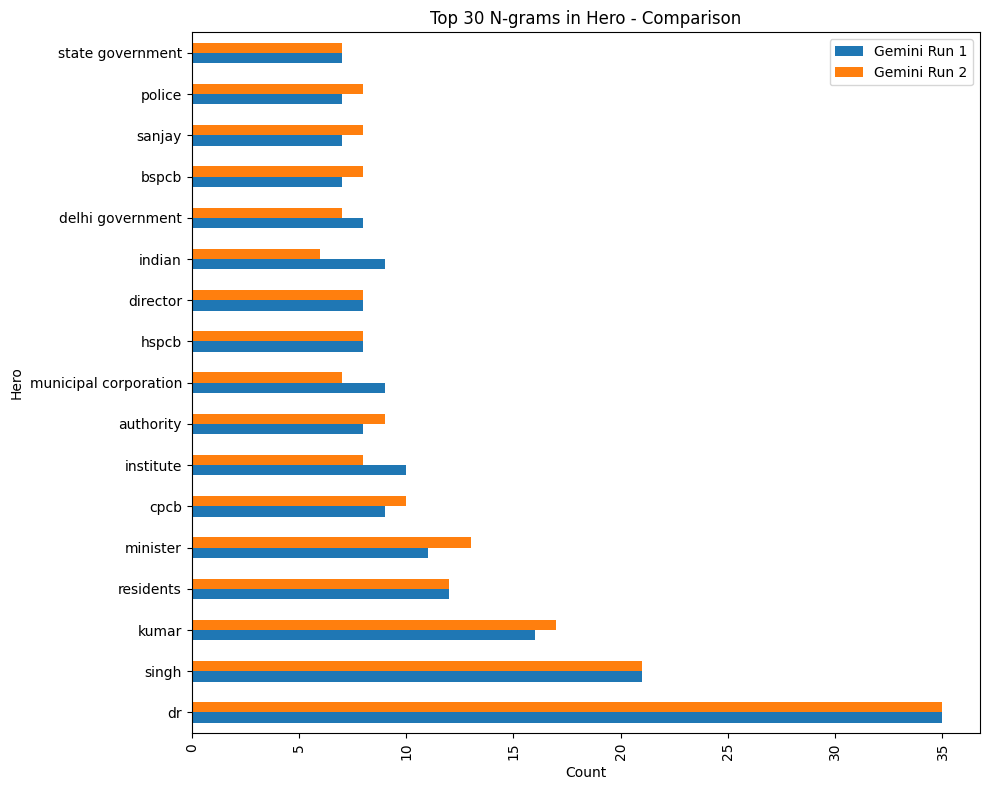

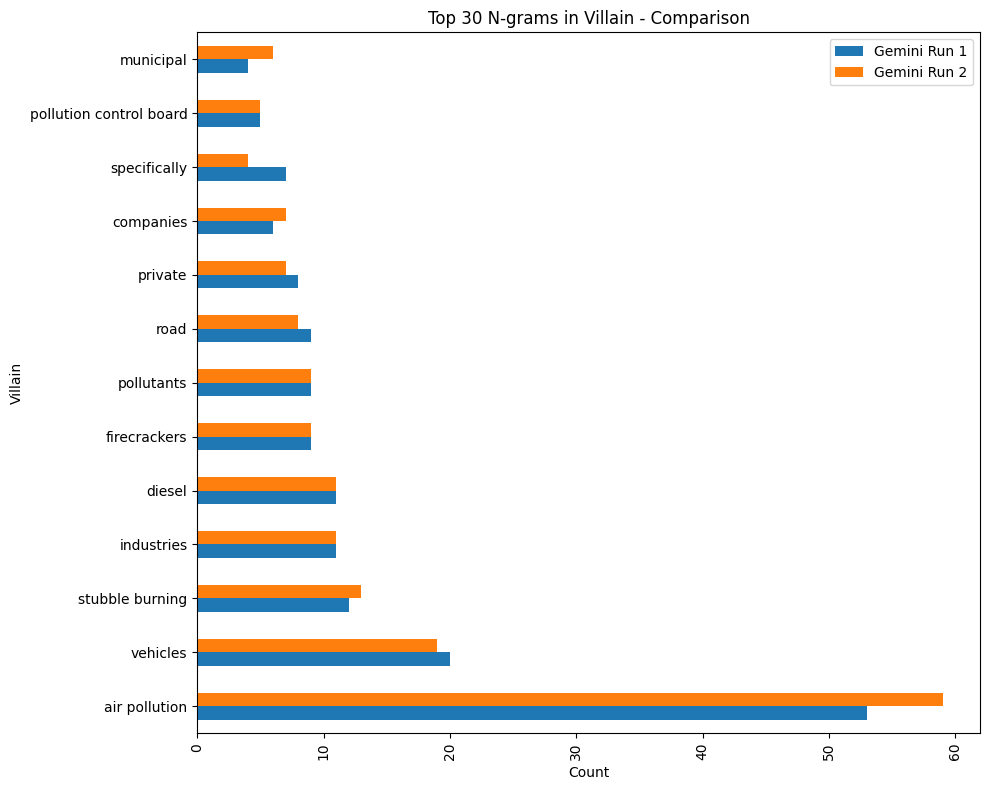

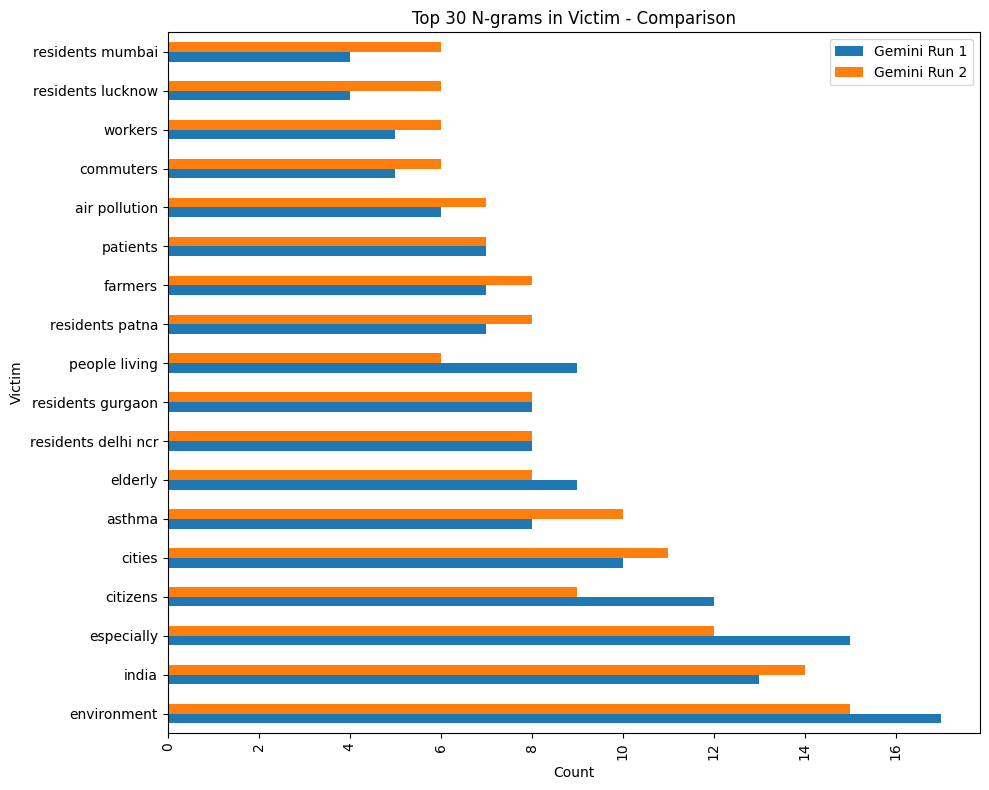

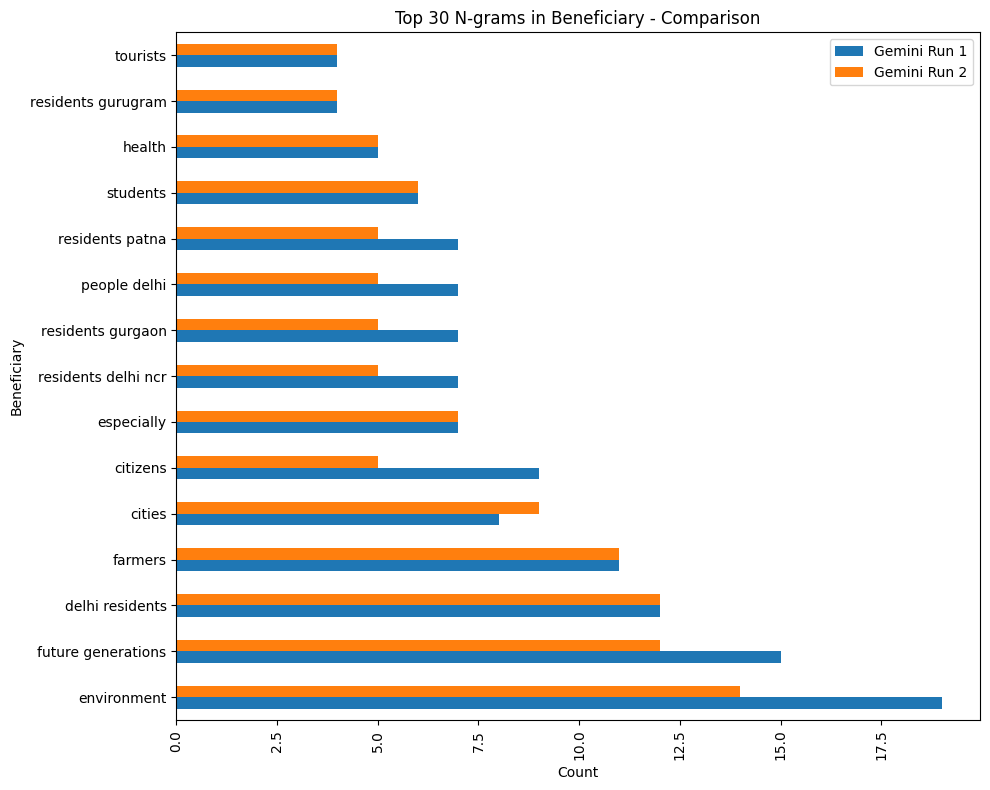

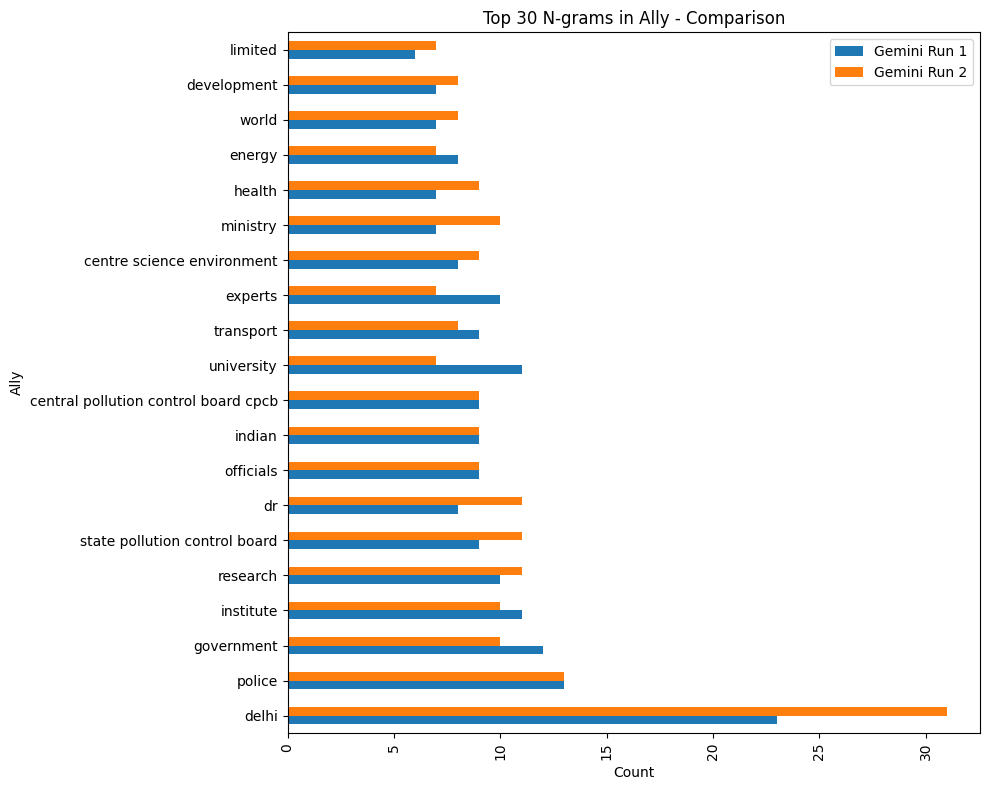

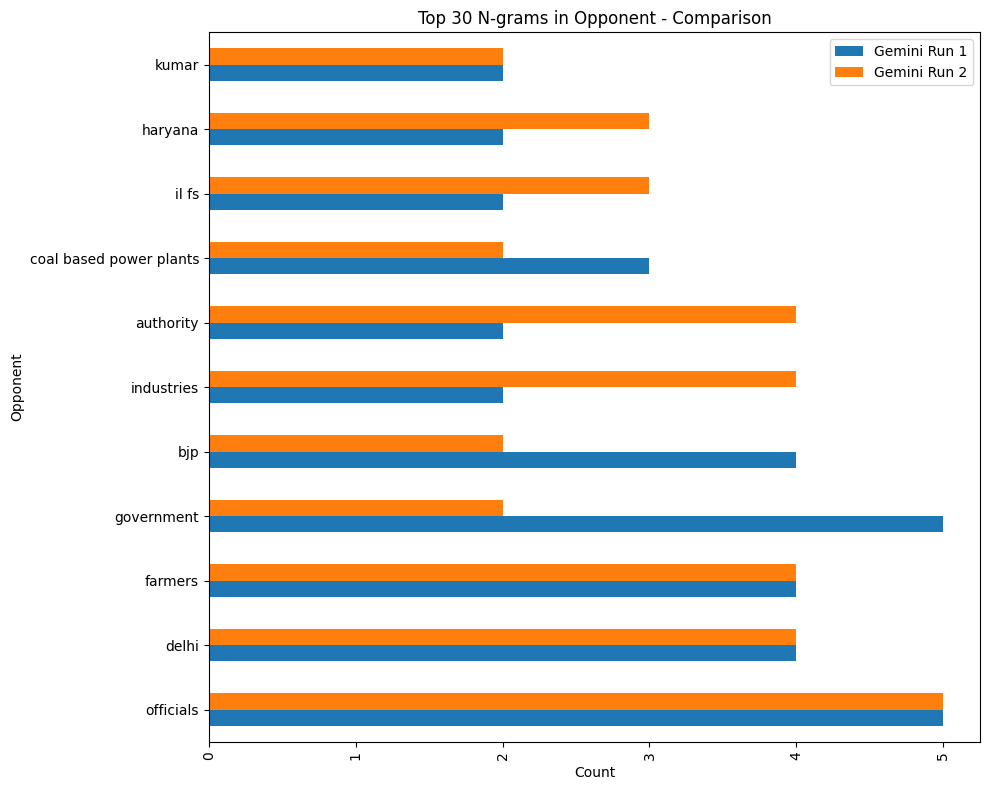

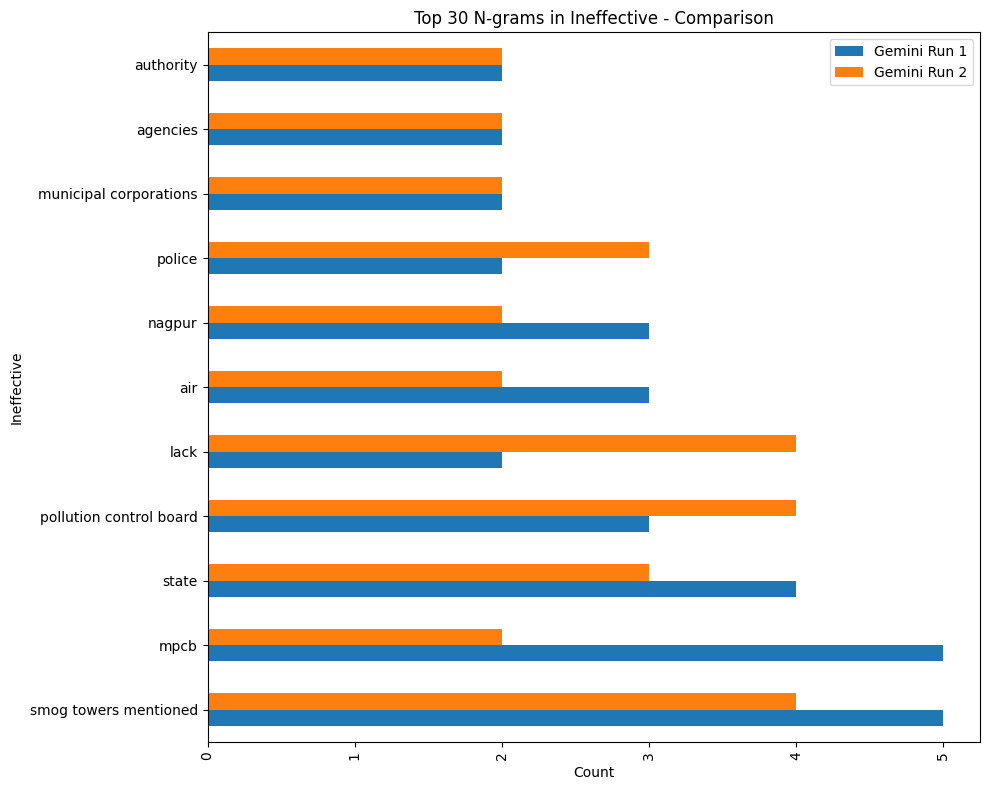

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

elements_full = ['Hero', 'Villain', 'Victim', 'Beneficiary', 'Ally', 'Opponent', 'Ineffective']

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 10), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

list_of_dfs = [df1, df2]

def remove_subsets(ngrams):
    to_remove = set()
    for i in range(len(ngrams)):
        for j in range(len(ngrams)):
            if i != j and ngrams[i][0] in ngrams[j][0]:
                to_remove.add(ngrams[i])
                break
    return [item for item in ngrams if item not in to_remove]

top_words_dict = {}
for element in elements_full:
    top_words_dict[element] = {}
    for i, dataf in enumerate(list_of_dfs):
        # Fill NaN values with an empty string
        dataf[element] = dataf[element].fillna('')

        common_words = get_top_n_words(dataf[element], 100)
        filtered_words = remove_subsets(common_words)

        df_counts = pd.DataFrame(filtered_words, columns=[element, 'count'])
        df_counts_grouped = df_counts.groupby(element).sum()['count'].sort_values(ascending=False).head(30)

        if dataf is df1:
            dataset = "Gemini Run 1"
        elif dataf is df2:
            dataset = "Gemini Run 2"

        # Save the top words for each element and dataset
        top_words_dict[element][dataset] = df_counts_grouped

# Combine data for comparison
for element in elements_full:
    df1_counts = top_words_dict[element]["Gemini Run 1"]
    df2_counts = top_words_dict[element]["Gemini Run 2"]

    # Find common words
    common_words = df1_counts.index.intersection(df2_counts.index)

    # Filter to keep only common words
    df1_counts = df1_counts[common_words]
    df2_counts = df2_counts[common_words]

    combined_df = pd.concat([df1_counts, df2_counts], axis=1, keys=['Gemini Run 1', 'Gemini Run 2']).fillna(0)
    combined_df.columns = ['Gemini Run 1', 'Gemini Run 2']

    # Sort combined data by the sum of the counts in descending order
    combined_df['Total'] = combined_df.sum(axis=1)
    combined_df = combined_df.sort_values(by='Total', ascending=False).drop(columns=['Total'])
    combined_df = combined_df.head(30)

    combined_df.plot(kind='barh', figsize=(10, 8))
    plt.title(f'Top 30 N-grams in {element} - Comparison')
    plt.xlabel('Count')
    plt.ylabel(element)
    plt.xticks(rotation=90)
    plt.tight_layout()
    filename = '/content/drive/MyDrive/Thesis/Gemini/characters/' + element + ".png"
    plt.savefig(filename)
    plt.show()


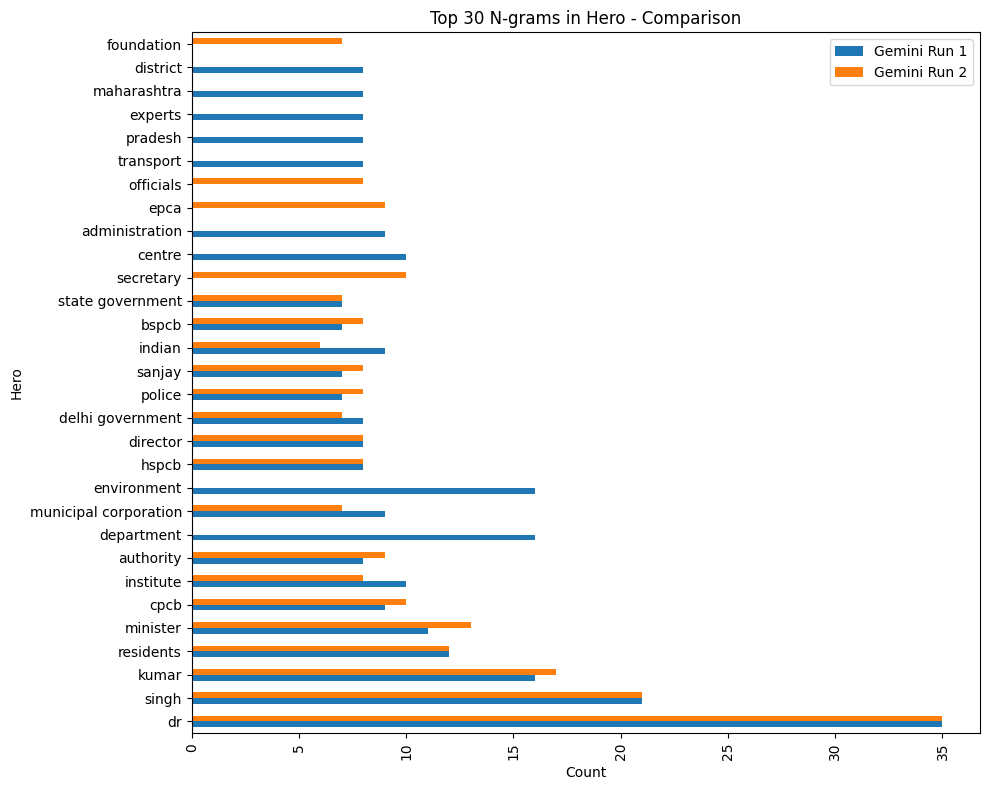

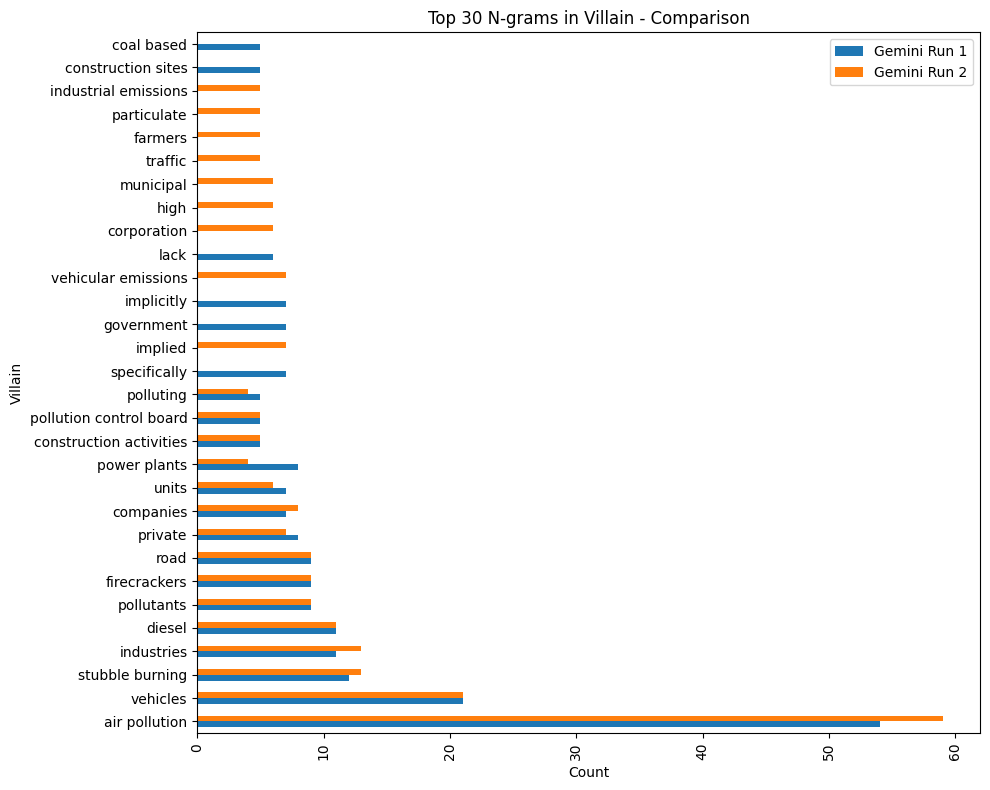

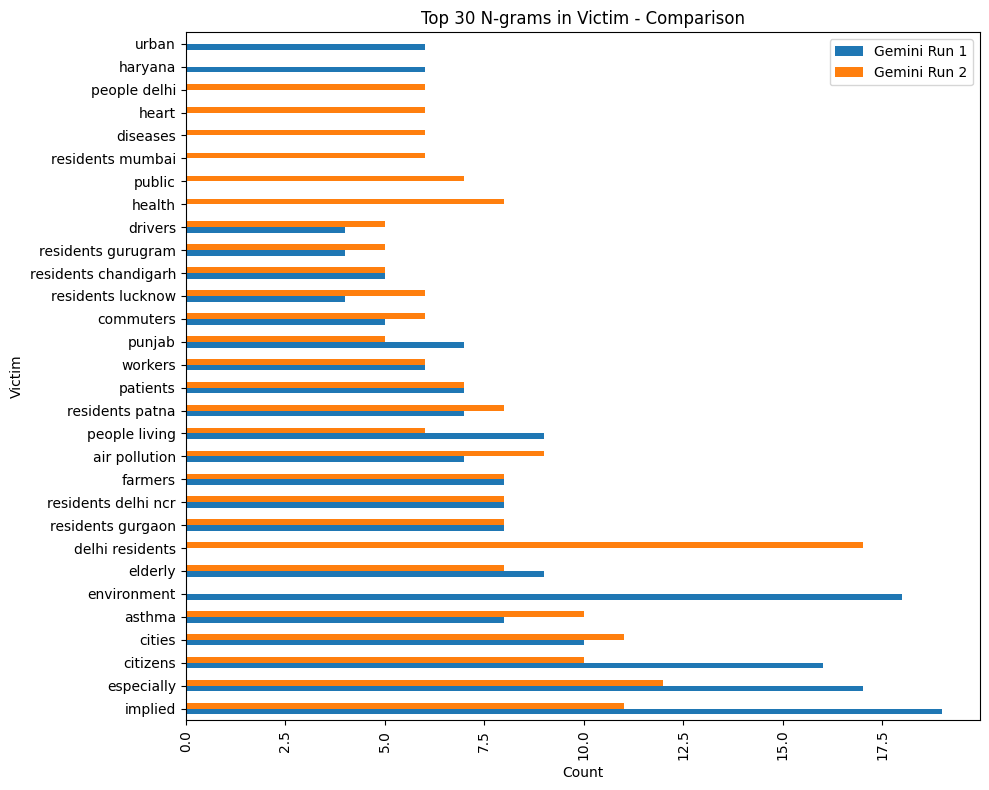

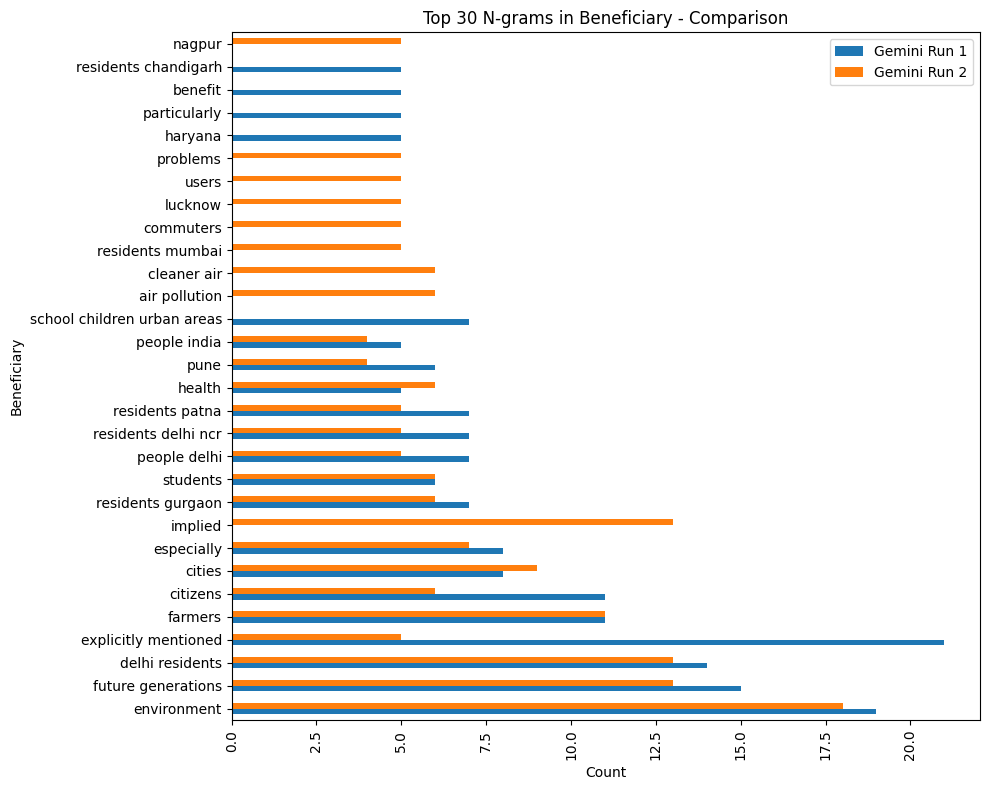

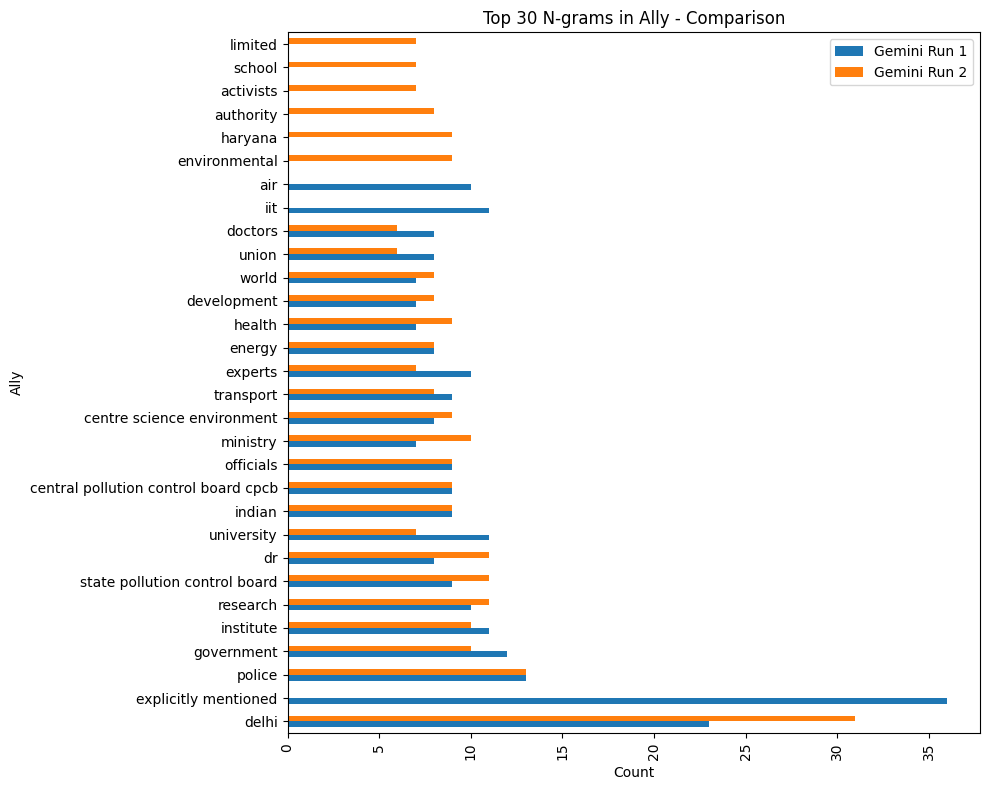

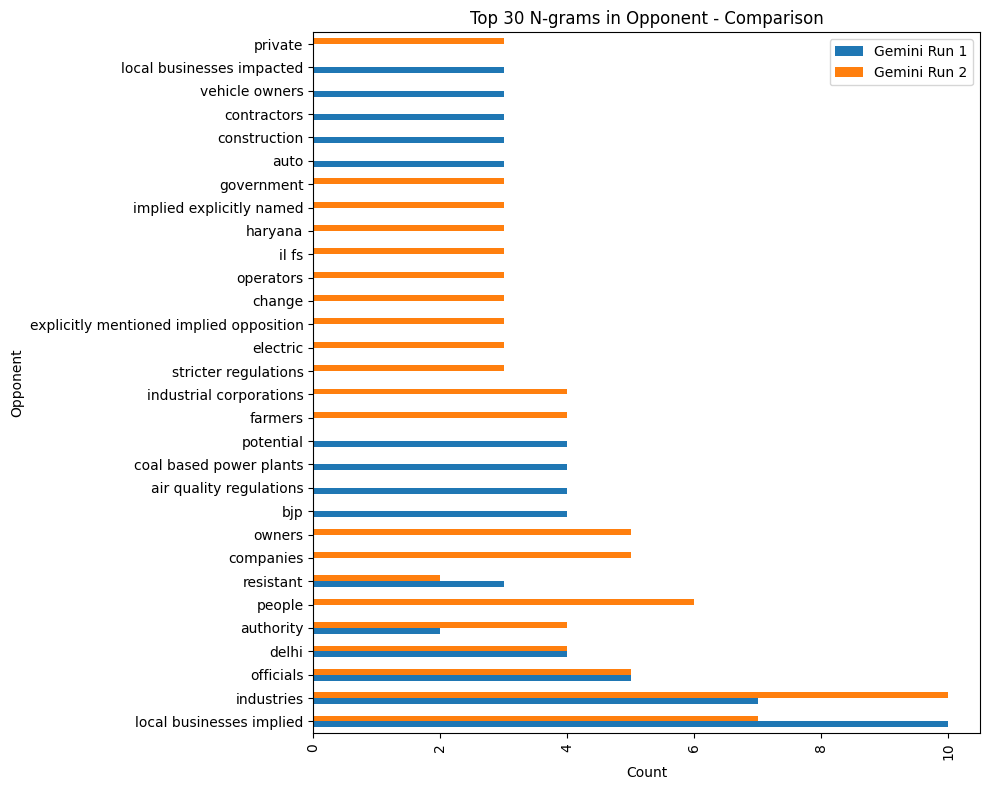

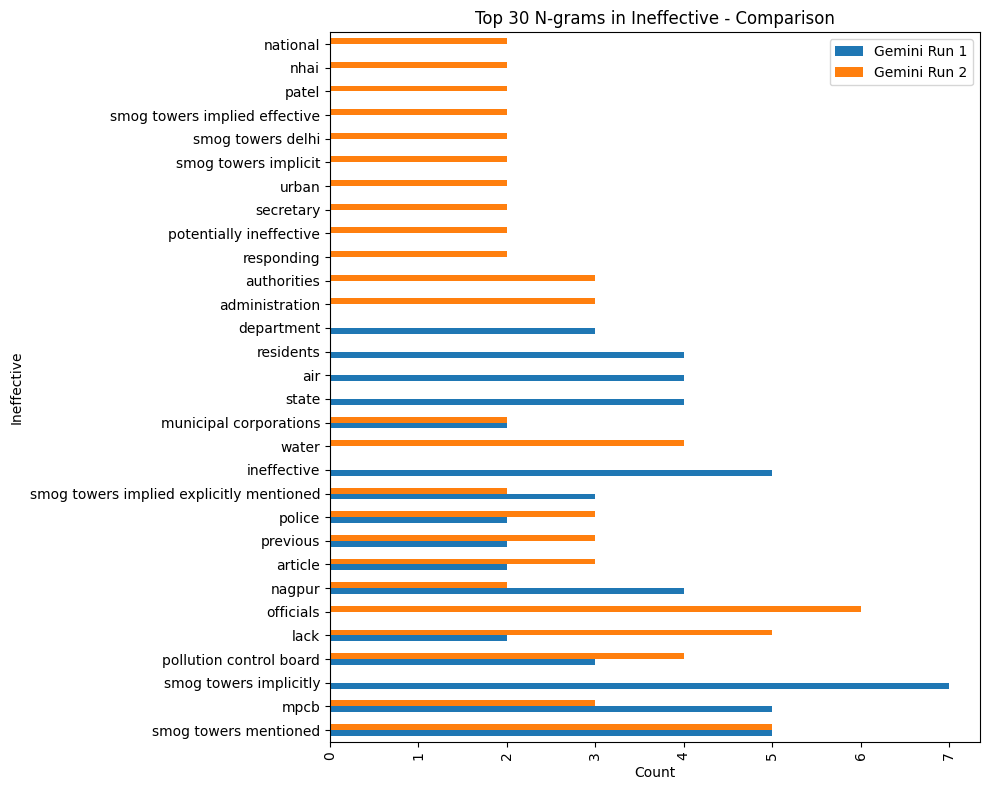

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

elements_full = ['Hero', 'Villain', 'Victim', 'Beneficiary', 'Ally', 'Opponent', 'Ineffective']

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 10), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

list_of_dfs = [df1, df2]

def remove_subsets(ngrams):
    to_remove = set()
    for i in range(len(ngrams)):
        for j in range(len(ngrams)):
            if i != j and ngrams[i][0] in ngrams[j][0]:
                to_remove.add(ngrams[i])
                break
    return [item for item in ngrams if item not in to_remove]

top_words_dict = {}
for element in elements_full:
    top_words_dict[element] = {}
    for i, dataf in enumerate(list_of_dfs):
        # Fill NaN values with an empty string
        dataf[element] = dataf[element].fillna('')

        common_words = get_top_n_words(dataf[element], 100)
        filtered_words = remove_subsets(common_words)

        df_counts = pd.DataFrame(filtered_words, columns=[element, 'count'])
        df_counts_grouped = df_counts.groupby(element).sum()['count'].sort_values(ascending=False).head(30)

        if dataf is df1:
            dataset = "Gemini Run 1"
        elif dataf is df2:
            dataset = "Gemini Run 2"

        # Save the top words for each element and dataset
        top_words_dict[element][dataset] = df_counts_grouped

# Combine data for comparison
for element in elements_full:
    df1_counts = top_words_dict[element]["Gemini Run 1"]
    df2_counts = top_words_dict[element]["Gemini Run 2"]

    combined_df = pd.concat([df1_counts, df2_counts], axis=1, keys=['Gemini Run 1', 'Gemini Run 2']).fillna(0)
    combined_df.columns = ['Gemini Run 1', 'Gemini Run 2']

    # Sort combined data by the sum of the counts in descending order
    combined_df['Total'] = combined_df.sum(axis=1)
    combined_df = combined_df.sort_values(by='Total', ascending=False).drop(columns=['Total'])
    combined_df = combined_df.head(30)

    combined_df.plot(kind='barh', figsize=(10, 8))
    plt.title(f'Top 30 N-grams in {element} - Comparison')
    plt.xlabel('Count')
    plt.ylabel(element)
    plt.xticks(rotation=90)
    plt.tight_layout()
    filename = '/content/drive/MyDrive/Thesis/Gemini/characters/' + element + ".png"
    plt.savefig(filename)
    plt.show()


In [ ]:

def find_word_occurrences(df, column_name, target_words):
    """
    Search for occurrences of the target words in the specified column of the dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe to search.
    column_name (str): The name of the column to search in.
    target_words (list): The words to search for.

    Returns:
    dict: A dictionary where keys are target words and values are lists of strings where the target words are found.
    """
    occurrences_dict = {word: [] for word in target_words}
    for doc in df[column_name].dropna():
        for word in target_words:
            if word in doc:
                occurrences_dict[word].append(doc)
    return occurrences_dict

df1.name = "Gemini Run 1"
df2.name = "Gemini Run 2"
df_truth.name = "Ground Truth"

for element in elements_full:
    for dataf in list_of_dfs:
        dataset_name = dataf.name
        top_words = top_words_dict[element][dataset_name]
        occurrences_dict = find_word_occurrences(dataf, element, top_words)
        print(f"Occurrences in {element} - {dataset_name}:")
        for word, occurrences in occurrences_dict.items():
            print(f"Occurrences of '{word}':")
            for occurrence in occurrences:
                print(occurrence)
            print("\n")

Occurrences in Hero - Ground Truth:
Occurrences of 'dr':
Sanjay Agarwal, Chandrashekhar Phansalkar, Mahendra Dhadke, and Abhijeet P Joshi
Residents of the village, NGO Gayatri Chetana Kendra, Rajesh Tank
environmental and health activists, human rights advocate Ashish Sagar, healthcare professionals, Prof Rajendra Prasad, Dr. Ashutosh Dubey
Justice Ramasubramanian, Madras High Court
members of FONRWA, N P Singh, general secretary Rajendra Shukla, chief advisor A N Dhawan, and senior vice president Suresh Tiwari, and K K Jain, RWA President V D Sharma, secretary general Suresh Krishnan
school children and various private organisations
director of Centre for Environment Occupational and Health (CEOH) Dr T K Joshi, Prime Minister Narendra Modi
Dr Virendra Singh
Children, students, doctors, Principal medical officer Dr Pradeep Sharma, student Bharat
Latur Municipal Corporation; Municipal corporations of Nagpur, Chandrapur, Amravati, Navi Mumbai, Ulhasnagar, Aurangabad; Geetanjali Kaushik
C

In [ ]:
# Exploratory Data Analysis (EDA)
print(df.describe())

       Policy Narrative
count        297.000000
mean           0.983165
std            0.128870
min            0.000000
25%            1.000000
50%            1.000000
75%            1.000000
max            1.000000


In [ ]:
def plot_co_occurrence_heatmap(df, col1, col2):
    """
    Plots a heatmap showing the co-occurrence of values in two specified columns.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    col1 (str): The name of the first column.
    col2 (str): The name of the second column.
    """
    # Group by the specified columns and count occurrences
    combinations = df.groupby([col1, col2]).size().reset_index(name='Count')

    # Create a pivot table
    pivot_table = combinations.pivot(index=col1, columns=col2, values='Count')

    # Fill NaN values with 0 for better visualization
    pivot_table = pivot_table.fillna(0)

    # Plot the heatmap
    sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='Blues')
    plt.title(f'Co-occurrence of {col1} and {col2}')
    plt.xticks(rotation=90)
    plt.show()

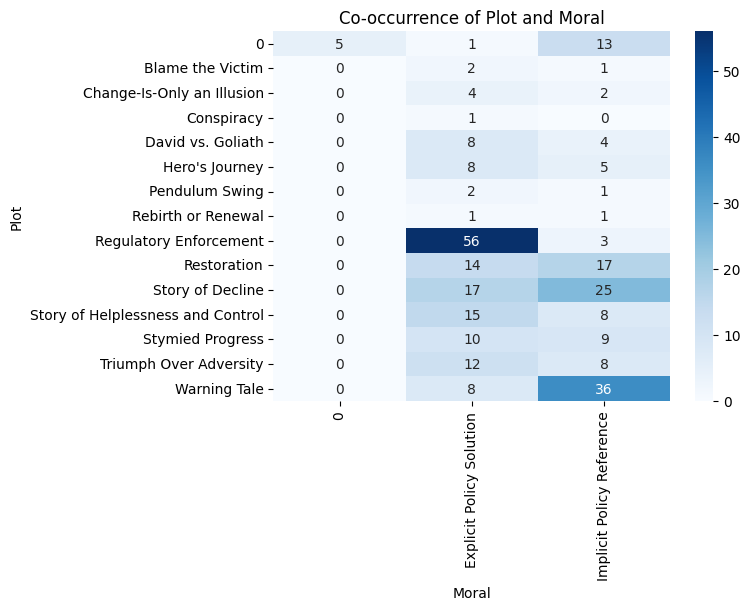

In [ ]:
plot_co_occurrence_heatmap(df, 'Plot', 'Moral')

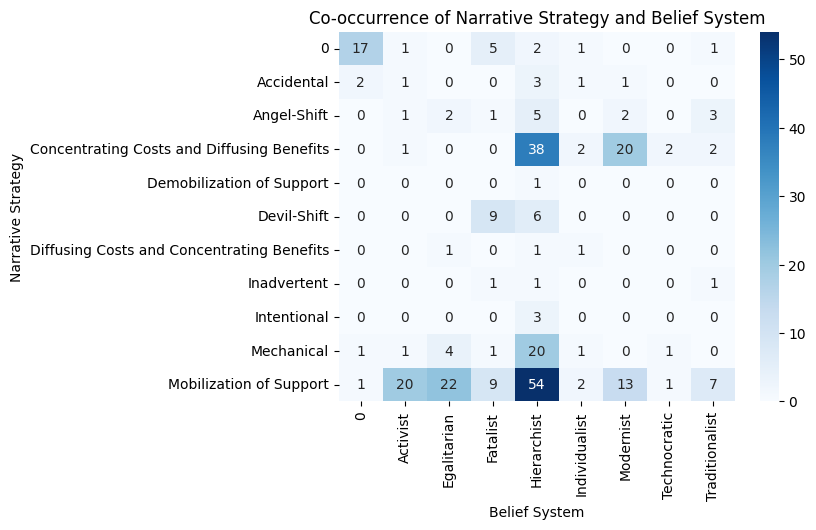

In [ ]:
plot_co_occurrence_heatmap(df, 'Narrative Strategy', 'Belief System')

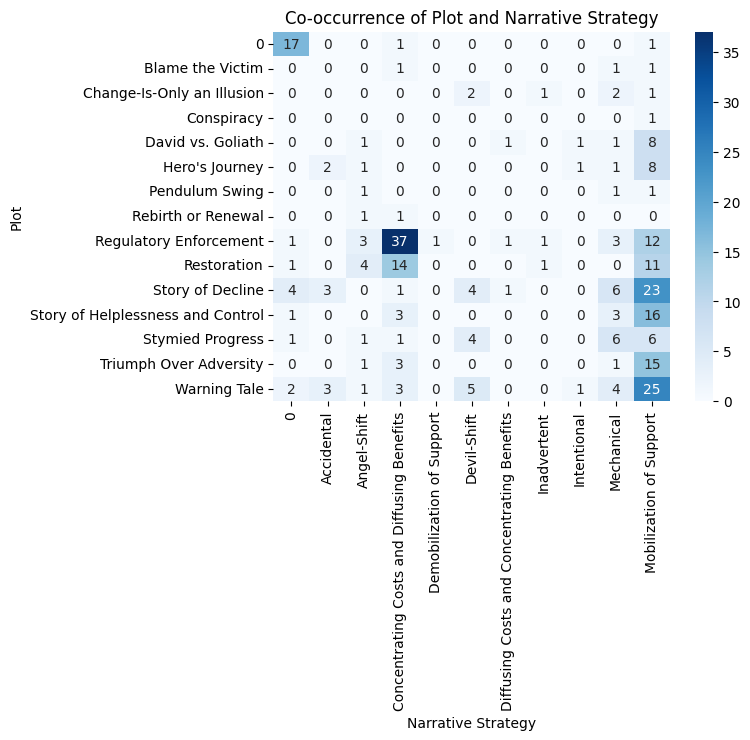

In [ ]:
plot_co_occurrence_heatmap(df, 'Plot', 'Narrative Strategy')

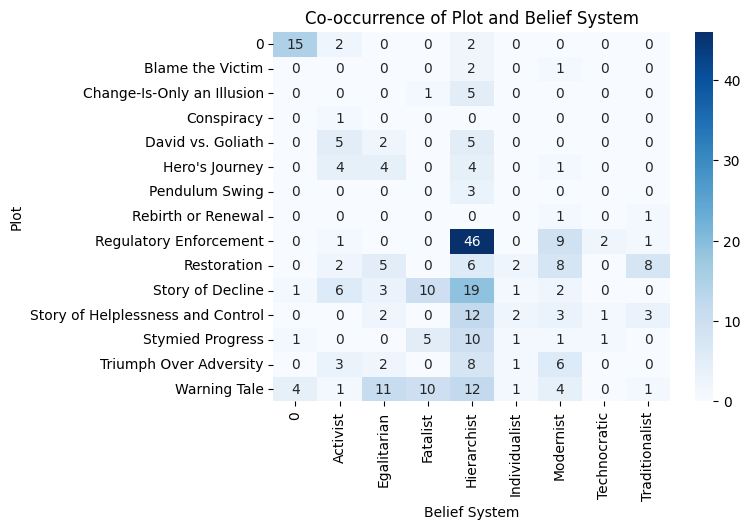

In [ ]:
plot_co_occurrence_heatmap(df, 'Plot', 'Belief System')

In [ ]:
# Statistical tests and other analyses
# Statistical Test: Chi-square test for independence between 'Plot' and 'Belief System'
contingency_table = pd.crosstab(df['Plot'], df['Belief System'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f'Chi-square test statistic: {chi2}, p-value: {p}')

Chi-square test statistic: 394.8733403448588, p-value: 3.4661331872936194e-33


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_frequency_comparison(df1, df2, column_name, offset_length = 5):
    # Get value counts for the specified column from both dataframes
    plot_counts1 = df1[column_name].value_counts().sort_index()
    plot_counts2 = df2[column_name].value_counts().sort_index()

    # Creating a new dataframe to hold the data side by side
    compare_df = pd.DataFrame({
        f'DF1 {column_name}': plot_counts1,
        f'DF2 {column_name}': plot_counts2
    })

    # Handle missing values
    compare_df.fillna(0, inplace=True)

    # Sort data by total count in descending order for better visualization
    compare_df.sort_values(f'DF1 {column_name}', ascending=False, inplace=True)

    # Plotting
    ax = compare_df[[f'DF1 {column_name}', f'DF2 {column_name}']].plot(kind='barh', figsize=(12, 8))

    # Rename legend labels
    ax.legend(['Gemini Run 1', 'Gemini Run 2'])

    # Annotating the difference in values as percentage
    total_length_df1 = len(df1)

    for i in range(compare_df.shape[0]):
        val1 = compare_df.iloc[i, 0]
        val2 = compare_df.iloc[i, 1]
        lower_val = min(val1, val2)


        offset = 0
        if val1 < val2:
            diff_percentage = abs(val1 - val2) / val2 * 100
            offset = -offset_length  # Shift upwards if Gemini Run 2 has a lower value
        else:
            diff_percentage = abs(val1 - val2) / val1 * 100
            offset = offset_length  # Shift downwards if Gemini Run 1 has a lower value
        ax.annotate(f'{-diff_percentage:.2f}%', xy=(lower_val, i),
                    xytext=(3, offset), textcoords="offset points", va='center', ha='left', color='black', fontsize=10)

    plt.title(column_name + ' Comparison')
    plt.xlabel('Count')
    plt.ylabel(column_name)

    plt.show()

# Example usage:
# plot_frequency_comparison(df1, df2, 'Plot')


In [ ]:
pip install krippendorff

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import krippendorff
from sklearn.preprocessing import LabelEncoder

def plot_frequency_comparison(df1, df2, column_name, offset_length=5):
    # Combine unique labels from both dataframes for fitting the encoder
    combined_unique_labels = pd.concat([df1[column_name], df2[column_name]]).unique()

    # Encode the categorical data
    le = LabelEncoder()
    le.fit(combined_unique_labels)

    df1_encoded = df1.copy()
    df2_encoded = df2.copy()
    df1_encoded[column_name] = le.transform(df1[column_name])
    df2_encoded[column_name] = le.transform(df2[column_name])

    # Get value counts for the specified column from both dataframes
    plot_counts1 = df1[column_name].value_counts().sort_index()
    plot_counts2 = df2[column_name].value_counts().sort_index()

    # Creating a new dataframe to hold the data side by side
    compare_df = pd.DataFrame({
        f'DF1 {column_name}': plot_counts1,
        f'DF2 {column_name}': plot_counts2
    })

    # Handle missing values by filling with 0 and ensure all categories are represented in both dataframes
    compare_df = compare_df.reindex(index=combined_unique_labels, fill_value=0)

    # Sort data by total count in descending order for better visualization
    compare_df.sort_values(f'DF1 {column_name}', ascending=False, inplace=True)

    # Prepare data for Krippendorff's alpha calculation
    data1 = df1_encoded[column_name].values
    data2 = df2_encoded[column_name].values

    # Overall Krippendorff's alpha
    overall_alpha = krippendorff.alpha(reliability_data=[data1, data2])
    print(f'Overall Krippendorff\'s alpha: {overall_alpha:.4f}')

    # Plotting
    ax = compare_df[[f'DF1 {column_name}', f'DF2 {column_name}']].plot(kind='barh', figsize=(12, 8), color=['blue', 'orange'])

    # Rename legend labels
    ax.legend(['Gemini Run 1', 'Gemini Run 2'])

    # Annotate bars with their counts
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width())}', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                    xytext=(5, 0), textcoords='offset points', va='center', ha='left', color='black', fontsize=10)

    # Annotate overall Krippendorff's alpha on the plot
    ax.annotate(f'Krippendorff\'s alpha: {overall_alpha:.4f}', xy=(0.5, 0.8), xycoords='axes fraction',
                ha='center', va='bottom', fontsize=12, color='black')

    plt.title(column_name + ' Comparison')
    plt.xlabel('Count')
    plt.ylabel(column_name)
    plt.show()

# Example usage:
# plot_frequency_comparison(df1, df2, 'YourColumnName')


Overall Krippendorff's alpha: 0.5822


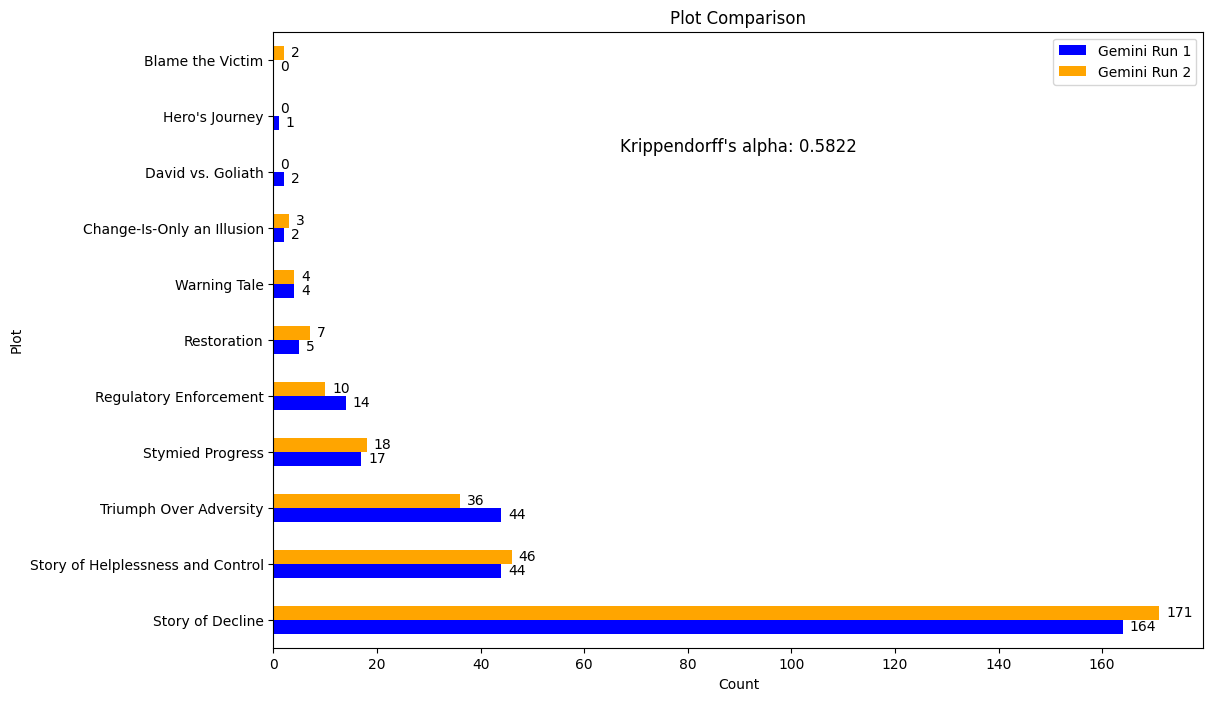

In [ ]:
plot_frequency_comparison(df1, df2, 'Plot')

Overall Krippendorff's alpha: 0.5167


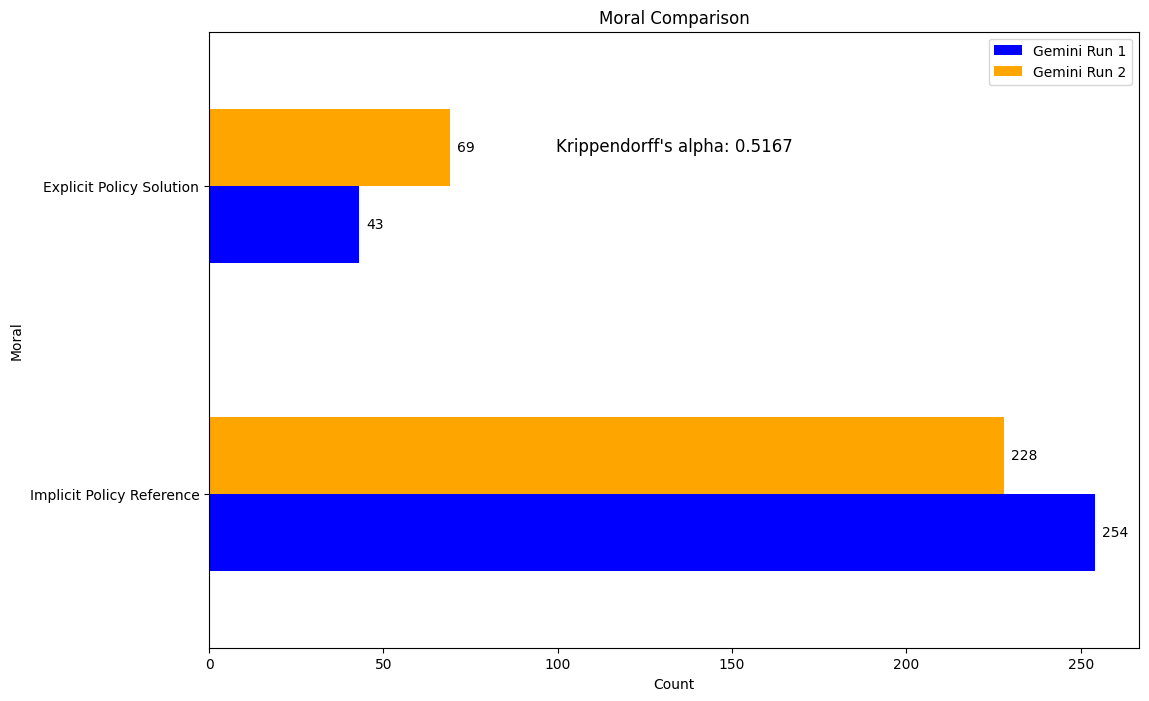

In [ ]:
plot_frequency_comparison(df1, df2, 'Moral', 30)

Overall Krippendorff's alpha: 0.5085


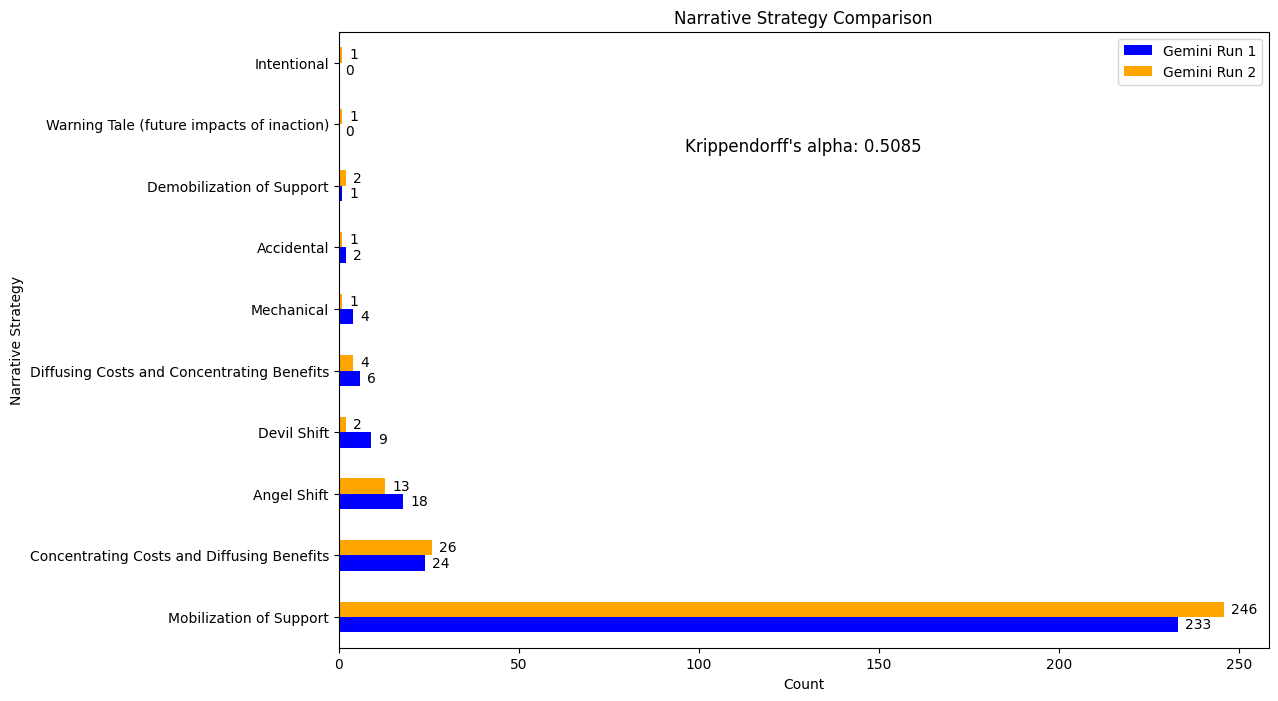

In [ ]:
plot_frequency_comparison(df1, df2, 'Narrative Strategy')

Overall Krippendorff's alpha: 0.8177


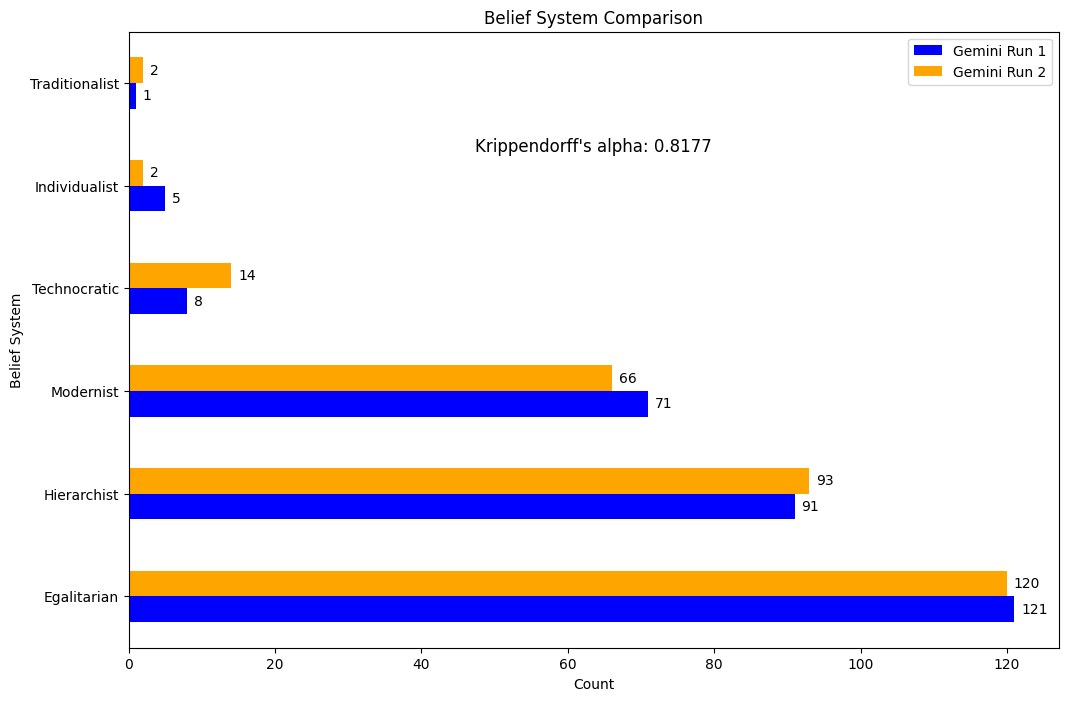

In [ ]:
plot_frequency_comparison(df1, df2, 'Belief System')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_frequency_comparison_three(df1, df2, df3, column_name, x_offset = 0, offset_length = 5):
    # Get value counts for the specified column from all three dataframes
    plot_counts1 = df1[column_name].value_counts().sort_index()
    plot_counts2 = df2[column_name].value_counts().sort_index()
    plot_counts3 = df3[column_name].value_counts().sort_index()

    # Creating a new dataframe to hold the data side by side
    compare_df = pd.DataFrame({
        f'DF1 {column_name}': plot_counts1,
        f'DF2 {column_name}': plot_counts2,
        f'DF3 {column_name}': plot_counts3
    })

    # Handle missing values
    compare_df.fillna(0, inplace=True)

    # Sort data by total count in descending order for better visualization
    compare_df.sort_values(f'DF1 {column_name}', ascending=False, inplace=True)

    # Plotting
    ax = compare_df[[f'DF1 {column_name}', f'DF2 {column_name}', f'DF3 {column_name}']].plot(kind='barh', figsize=(12, 8))

    # Rename legend labels
    ax.legend(['Gemini Run 1', 'Gemini Run 2', 'Ground Truth'])

    # Annotating the difference in values as percentage
    total_length_df1 = len(df1)

    for i in range(compare_df.shape[0]):
        val1 = compare_df.iloc[i, 0]
        val2 = compare_df.iloc[i, 1]
        val3 = compare_df.iloc[i, 2]

        avg_val1_val2 = (val1 + val2) / 2
        offset = 0
        if avg_val1_val2 < val3:
            diff_percentage = abs(avg_val1_val2 - val3) / val3 * 100
            offset = -offset_length # Shift upwards if Ground Truth has a higher value
        else:
            diff_percentage = abs(avg_val1_val2 - val3) / avg_val1_val2 * 100
            offset = offset_length # Shift downwards if Ground Truth has a lower value

        ax.annotate(f'{-diff_percentage:.2f}%', xy=(min(avg_val1_val2, val3)+x_offset, i),
                    xytext=(3, offset), textcoords="offset points", va='center', ha='left', color='black', fontsize=10)

    plt.title(column_name + ' Comparison')
    plt.xlabel('Count')
    plt.ylabel(column_name)

    plt.show()

# Example usage:
# plot_frequency_comparison_three(df1, df2, df3, 'Plot')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_frequency_comparison_three(df1, df2, df3, column_name, bar_width=0.8):  # Adjust the default width for thicker bars
    # Combine unique labels from all three dataframes for fitting the encoder
    combined_unique_labels = pd.concat([df1[column_name], df2[column_name], df3[column_name]]).unique()

    # Encode the categorical data
    le = LabelEncoder()
    le.fit(combined_unique_labels)

    df1_encoded = df1.copy()
    df2_encoded = df2.copy()
    df3_encoded = df3.copy()
    df1_encoded[column_name] = le.transform(df1[column_name])
    df2_encoded[column_name] = le.transform(df2[column_name])
    df3_encoded[column_name] = le.transform(df3[column_name])

    # Get value counts for the specified column from all three dataframes
    plot_counts1 = df1[column_name].value_counts().sort_index()
    plot_counts2 = df2[column_name].value_counts().sort_index()
    plot_counts3 = df3[column_name].value_counts().sort_index()

    # Creating a new dataframe to hold the data side by side
    compare_df = pd.DataFrame({
        f'DF1 {column_name}': plot_counts1,
        f'DF2 {column_name}': plot_counts2,
        f'DF3 {column_name}': plot_counts3
    })

    # Handle missing values by filling with 0 and ensure all categories are represented in all dataframes
    compare_df = compare_df.reindex(index=combined_unique_labels, fill_value=0)

    # Sort data by total count in descending order for better visualization
    compare_df.sort_values(f'DF1 {column_name}', ascending=False, inplace=True)

    # Prepare data for Krippendorff's alpha calculation
    data1 = df1_encoded[column_name].values
    data2 = df2_encoded[column_name].values
    data3 = df3_encoded[column_name].values

    # Overall Krippendorff's alpha for df3 vs df1 and df3 vs df2
    alpha_df3_df1 = krippendorff.alpha(reliability_data=[data3, data1])
    alpha_df3_df2 = krippendorff.alpha(reliability_data=[data3, data2])

    # Plotting
    ax = compare_df[[f'DF1 {column_name}', f'DF2 {column_name}', f'DF3 {column_name}']].plot(kind='barh', figsize=(12, 8), width=bar_width)  # Adjust bar width here

    # Rename legend labels
    ax.legend(['Gemini Run 1', 'Gemini Run 2', 'Ground Truth'])

    # Annotating the counts on bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width())}', (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                    xytext=(5, 0), textcoords='offset points', va='center', ha='left', color='black', fontsize=10)

    # Annotate overall Krippendorff's alphas on the plot
    plt.figtext(0.5, 0.8, f'Krippendorff\'s alpha (Ground Truth vs Gemini Run 1): {alpha_df3_df1:.4f}\n'
                             f'Krippendorff\'s alpha (Ground Truth vs Gemini Run 2): {alpha_df3_df2:.4f}',
                ha='center', fontsize=12, color='black')


    plt.title(column_name + ' Comparison')
    plt.xlabel('Count')
    plt.ylabel(column_name)

    plt.show()

# Example usage:
# plot_frequency_comparison_three(df1, df2, df3, 'Plot', bar_width=1.0)  # Increase bar_width as needed


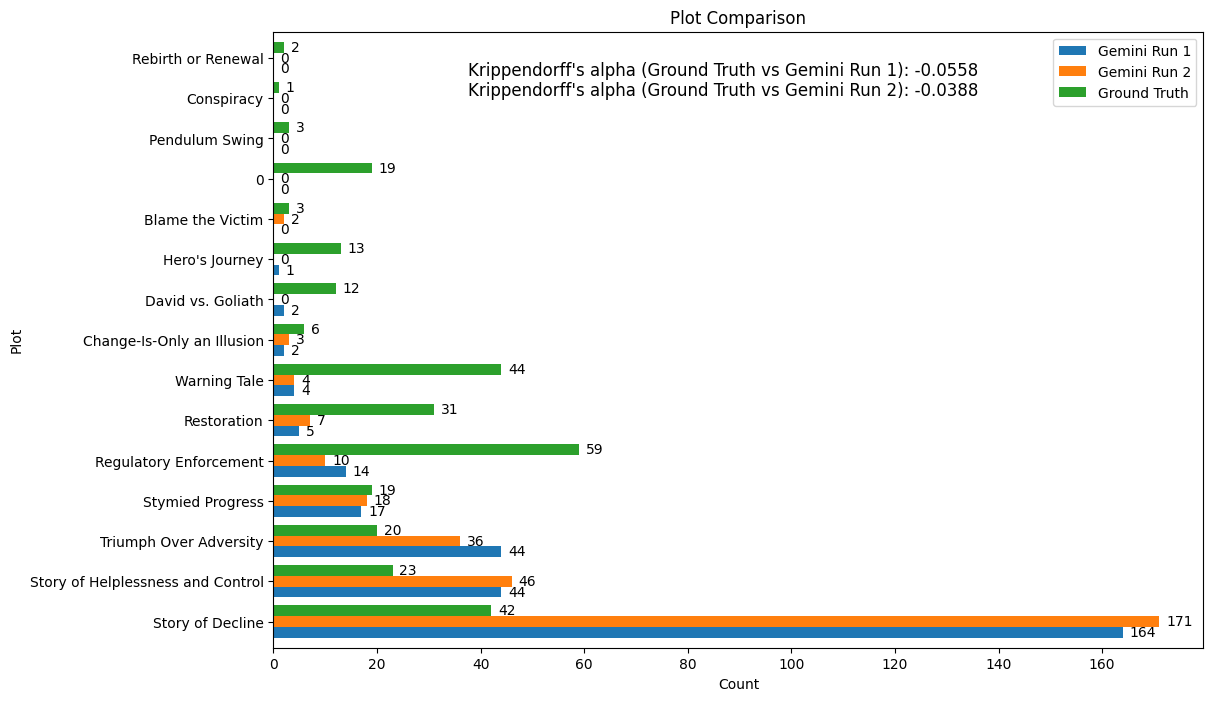

In [ ]:
plot_frequency_comparison_three(df1, df2, df_truth, 'Plot')

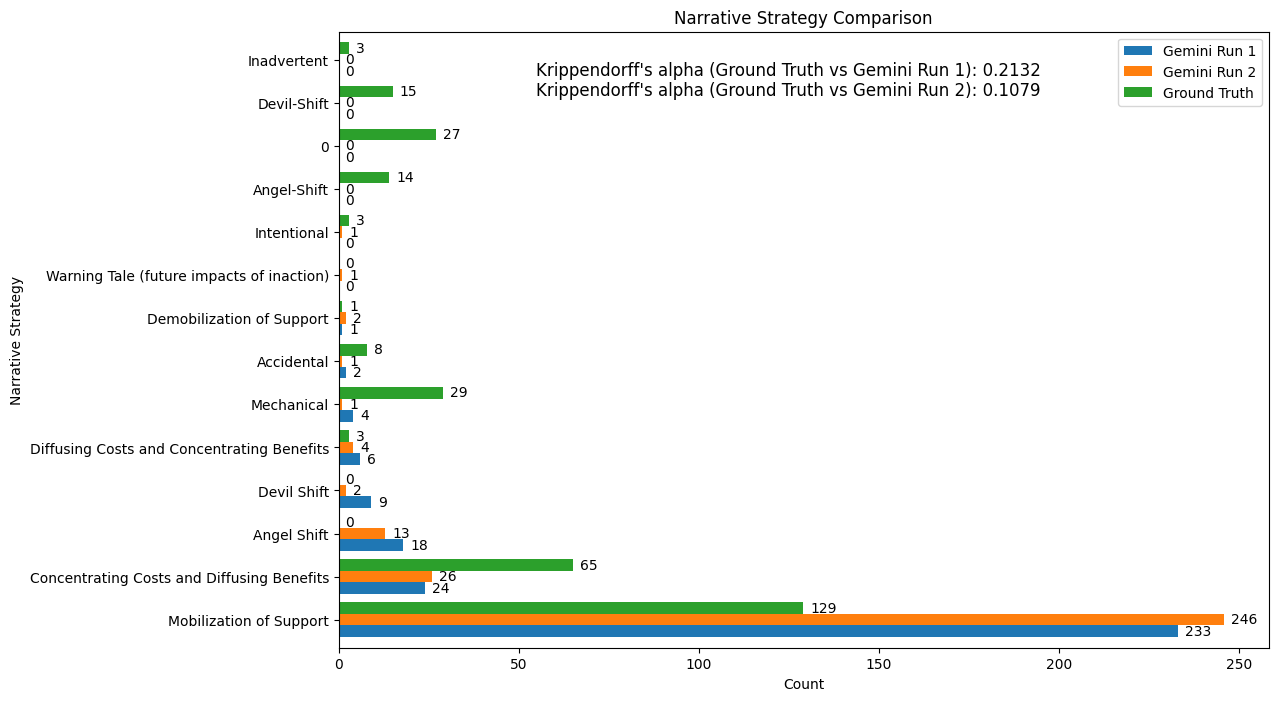

In [ ]:
plot_frequency_comparison_three(df1, df2, df_truth, 'Narrative Strategy')

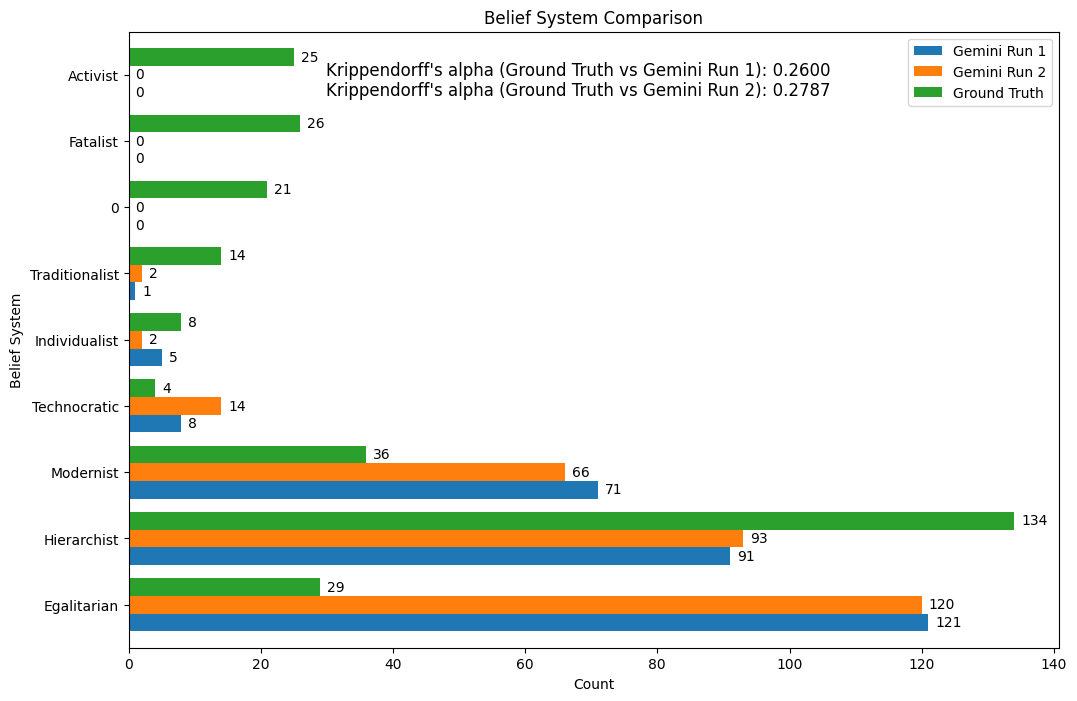

In [ ]:
plot_frequency_comparison_three(df1, df2, df_truth, 'Belief System')

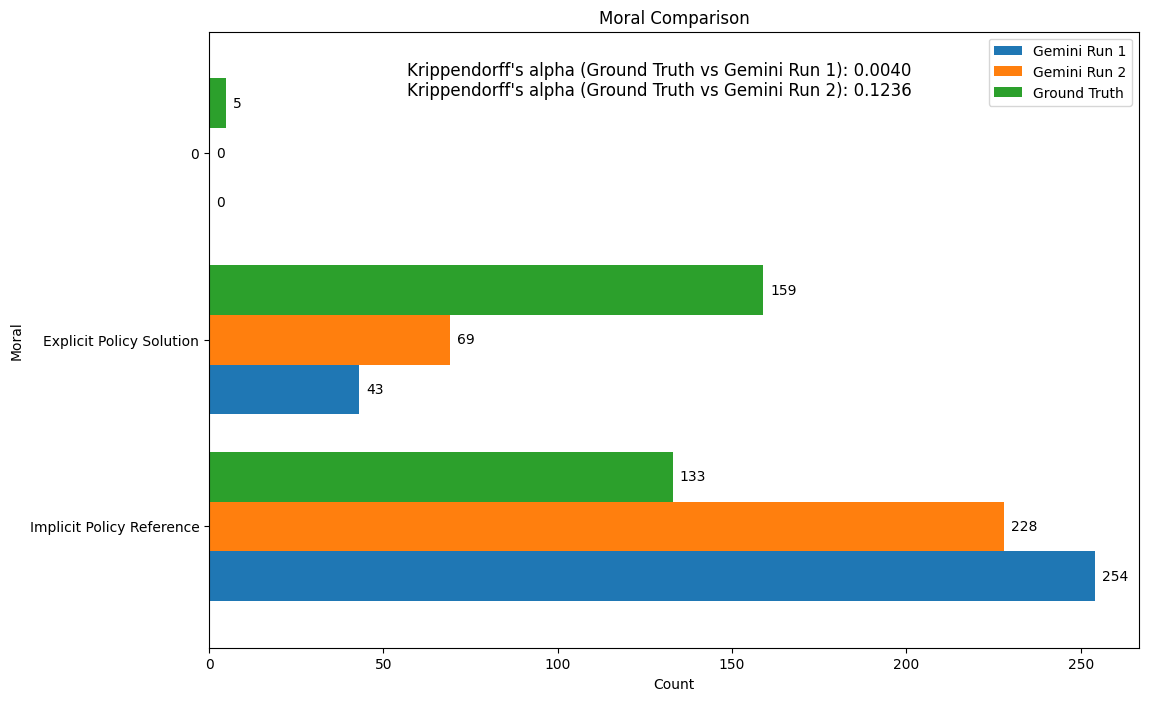

In [ ]:
plot_frequency_comparison_three(df1, df2, df_truth, 'Moral')

In [ ]:
import matplotlib.pyplot as plt

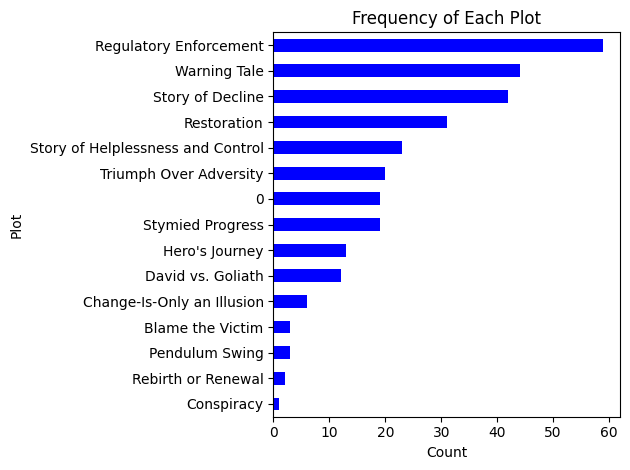

In [ ]:
def counts_for_elements(df, element):
  plot_counts = df[element].value_counts().sort_values(ascending=True)
  plot_counts.plot(kind='barh', color='blue')
  plt.title(f'Frequency of Each {element}')
  plt.xlabel('Count')
  plt.ylabel(element)
  plt.style.use('default') # Reset style to default
  plt.tight_layout()
  plt.show()

# Frequency of each 'Plot'
counts_for_elements(df_truth, 'Plot')

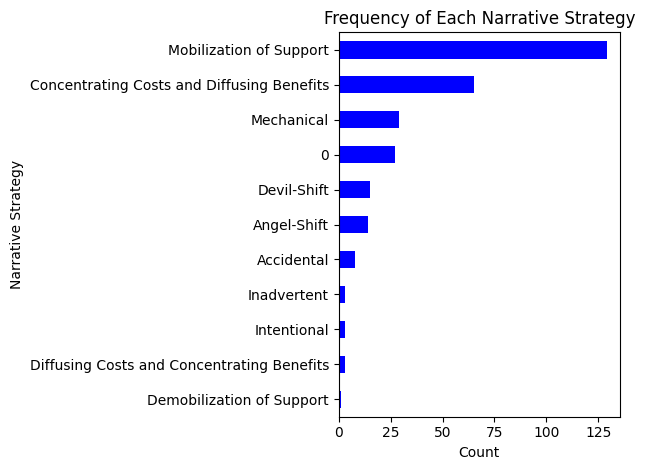

In [ ]:
counts_for_elements(df_truth, 'Narrative Strategy')

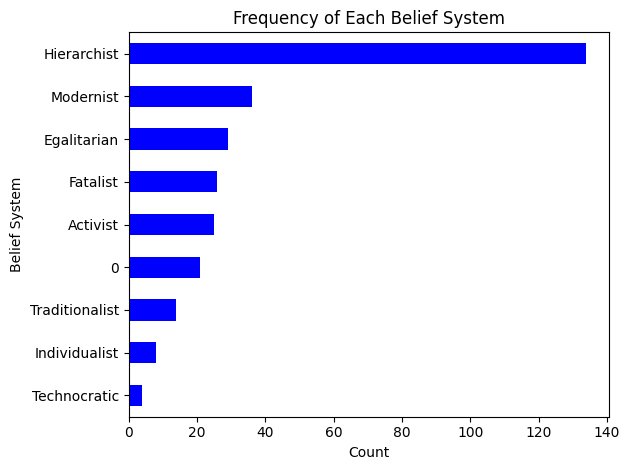

In [ ]:
counts_for_elements(df_truth, 'Belief System')

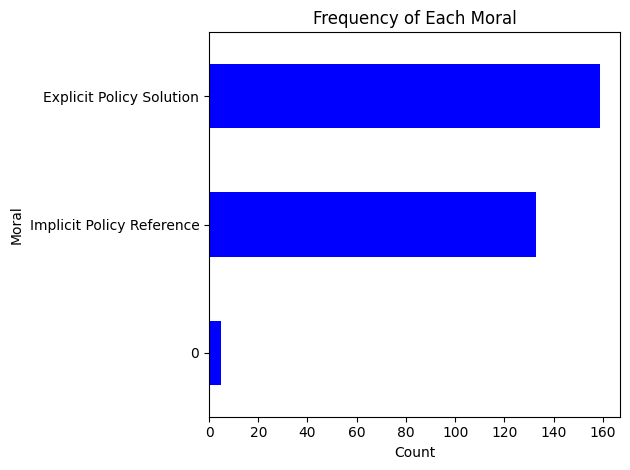

In [ ]:
counts_for_elements(df_truth, 'Moral')

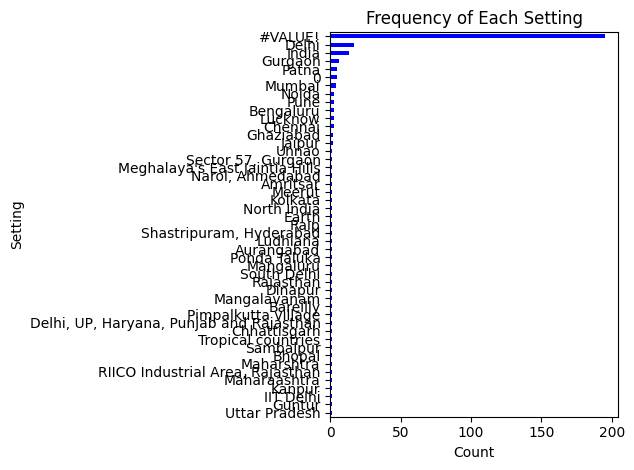

In [ ]:
counts_for_elements(df_truth, 'Setting')

In [ ]:
df = df_truth.copy()

In [ ]:
# Preprocess the data: Select the columns you want to cluster on
columns_to_cluster = ['Plot', 'Moral', 'Narrative Strategy', 'Belief System']
df_cluster = df[columns_to_cluster].astype(str)

# One-hot encode the categorical variables
encoder = OneHotEncoder()
df_encoded = encoder.fit_transform(df_cluster).toarray()

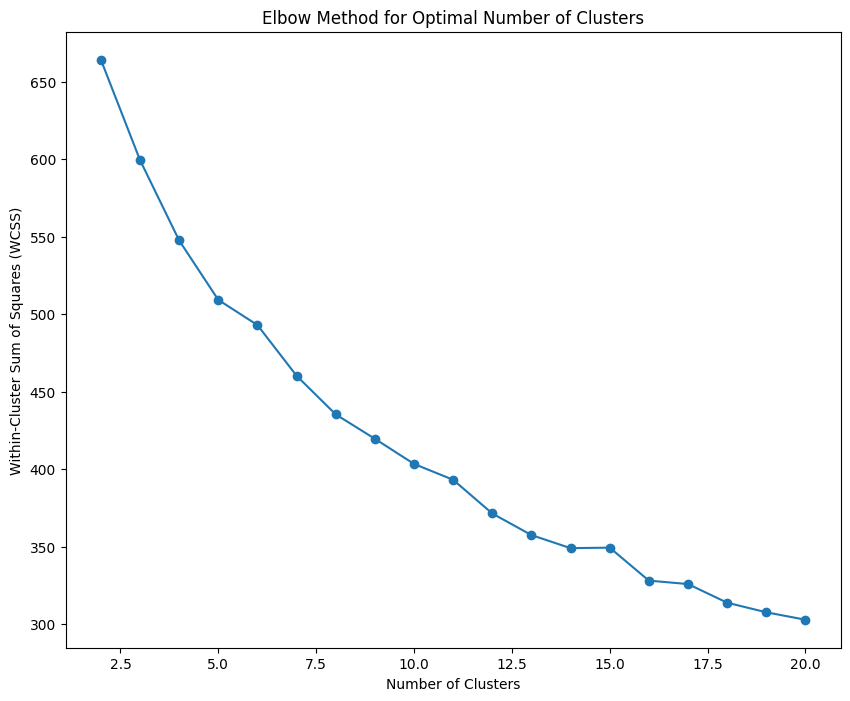

In [ ]:
# Elbow Method
wcss = []
range_n_clusters = list(range(2, 21))  # You can adjust the range as needed

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(df_encoded)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 8))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

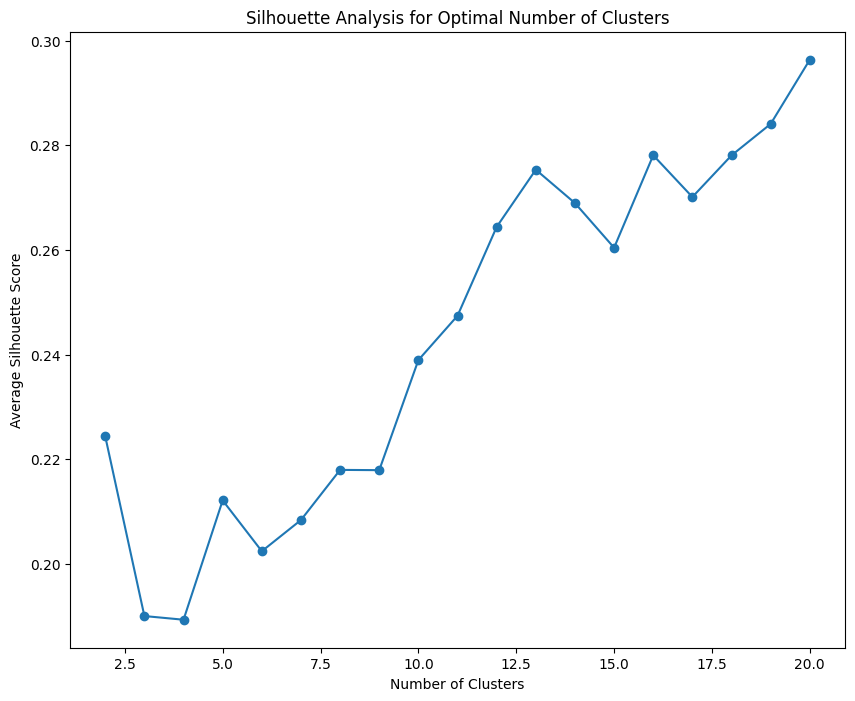

In [ ]:
# Silhouette Analysis
silhouette_avg = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_encoded)
    silhouette_avg.append(silhouette_score(df_encoded, cluster_labels))

# Plot Silhouette Analysis
plt.figure(figsize=(10, 8))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Silhouette Analysis for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

In [ ]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=13, random_state=42, n_init=10)  # Adjust the number of clusters as needed
clusters = kmeans.fit_predict(df_encoded)

In [ ]:
# Add the cluster labels to the original dataframe
df['Cluster'] = clusters

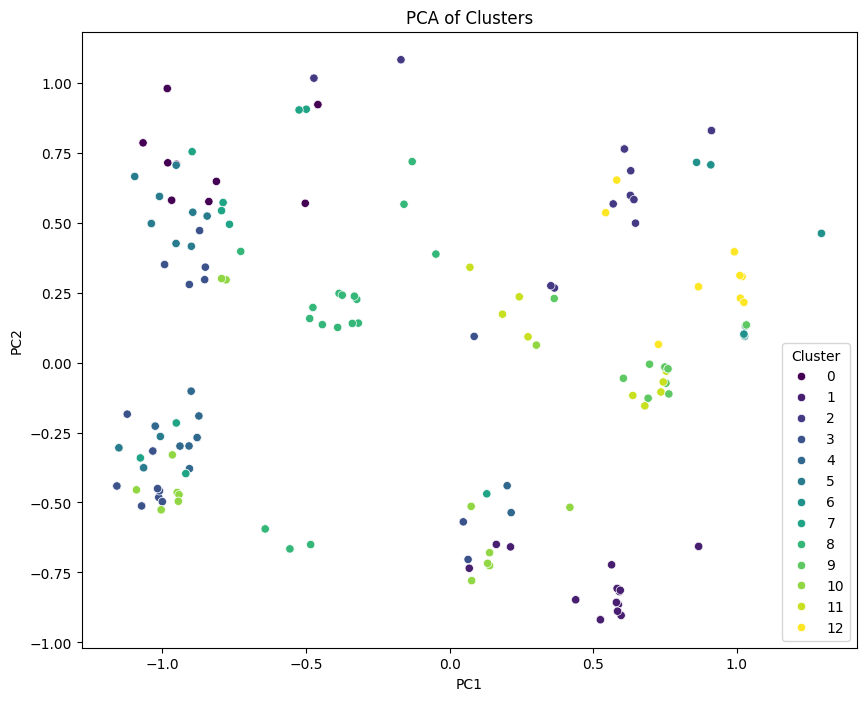

In [ ]:
# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_encoded)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters

# Plot the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=df_pca, legend='full')
plt.title('PCA of Clusters')
plt.show()

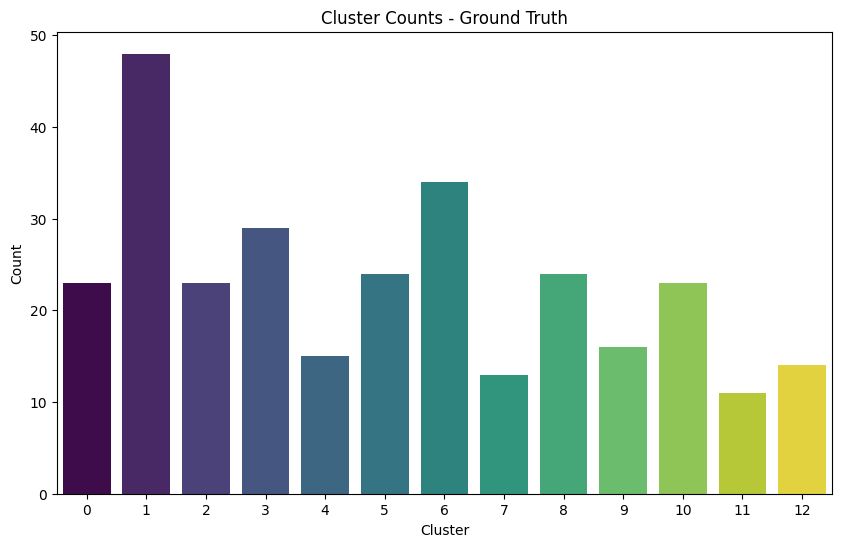

In [ ]:
# Calculate the counts for each cluster
cluster_counts = df['Cluster'].value_counts().sort_values(ascending=True)

# Plot Cluster Counts
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, legend=False, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Counts - Ground Truth')
plt.show()

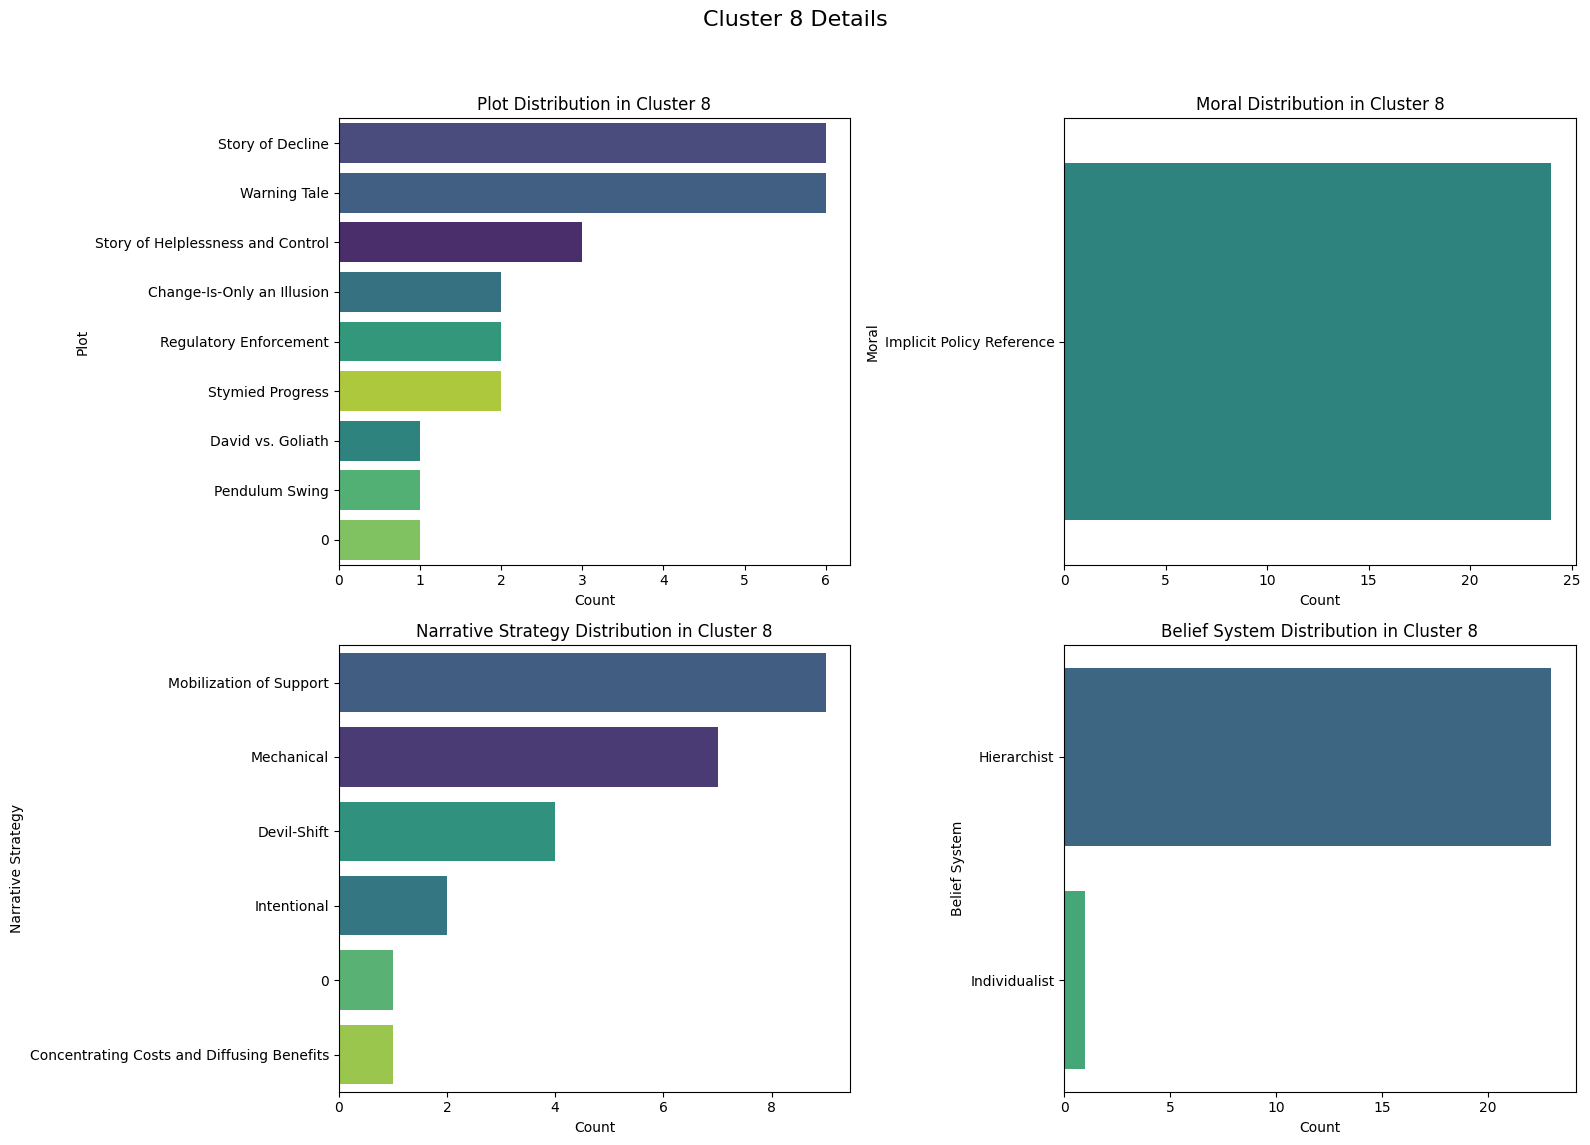

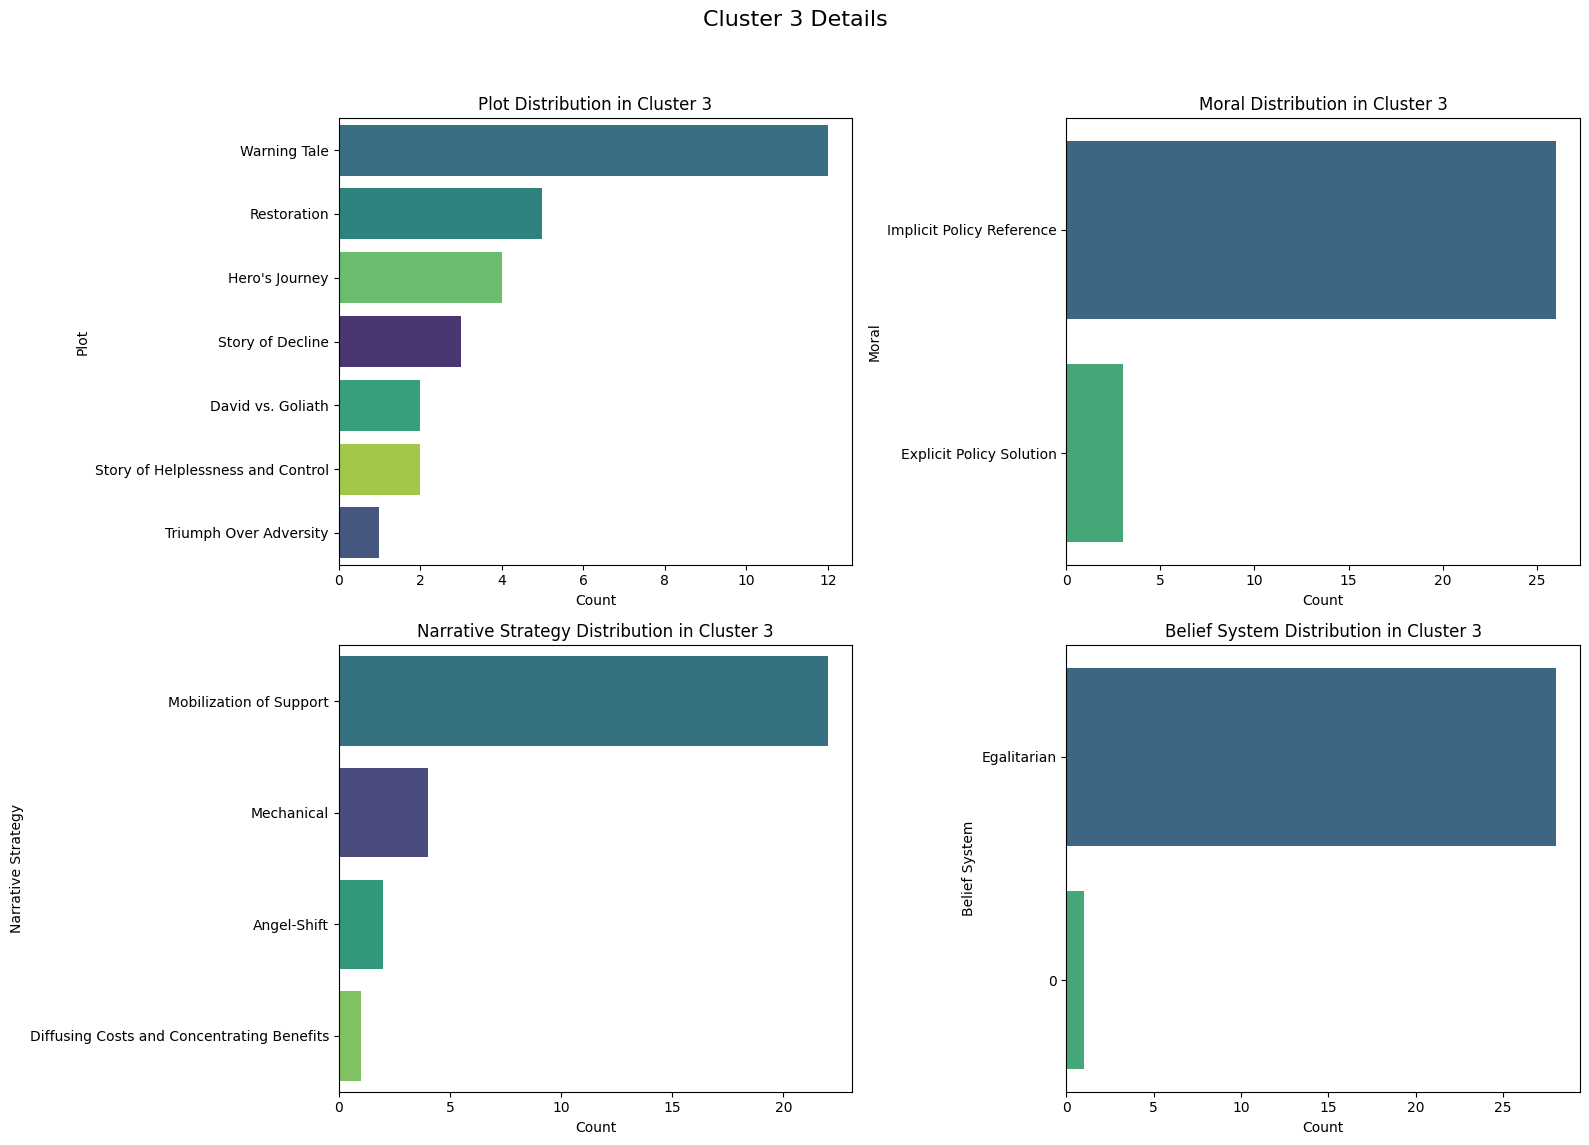

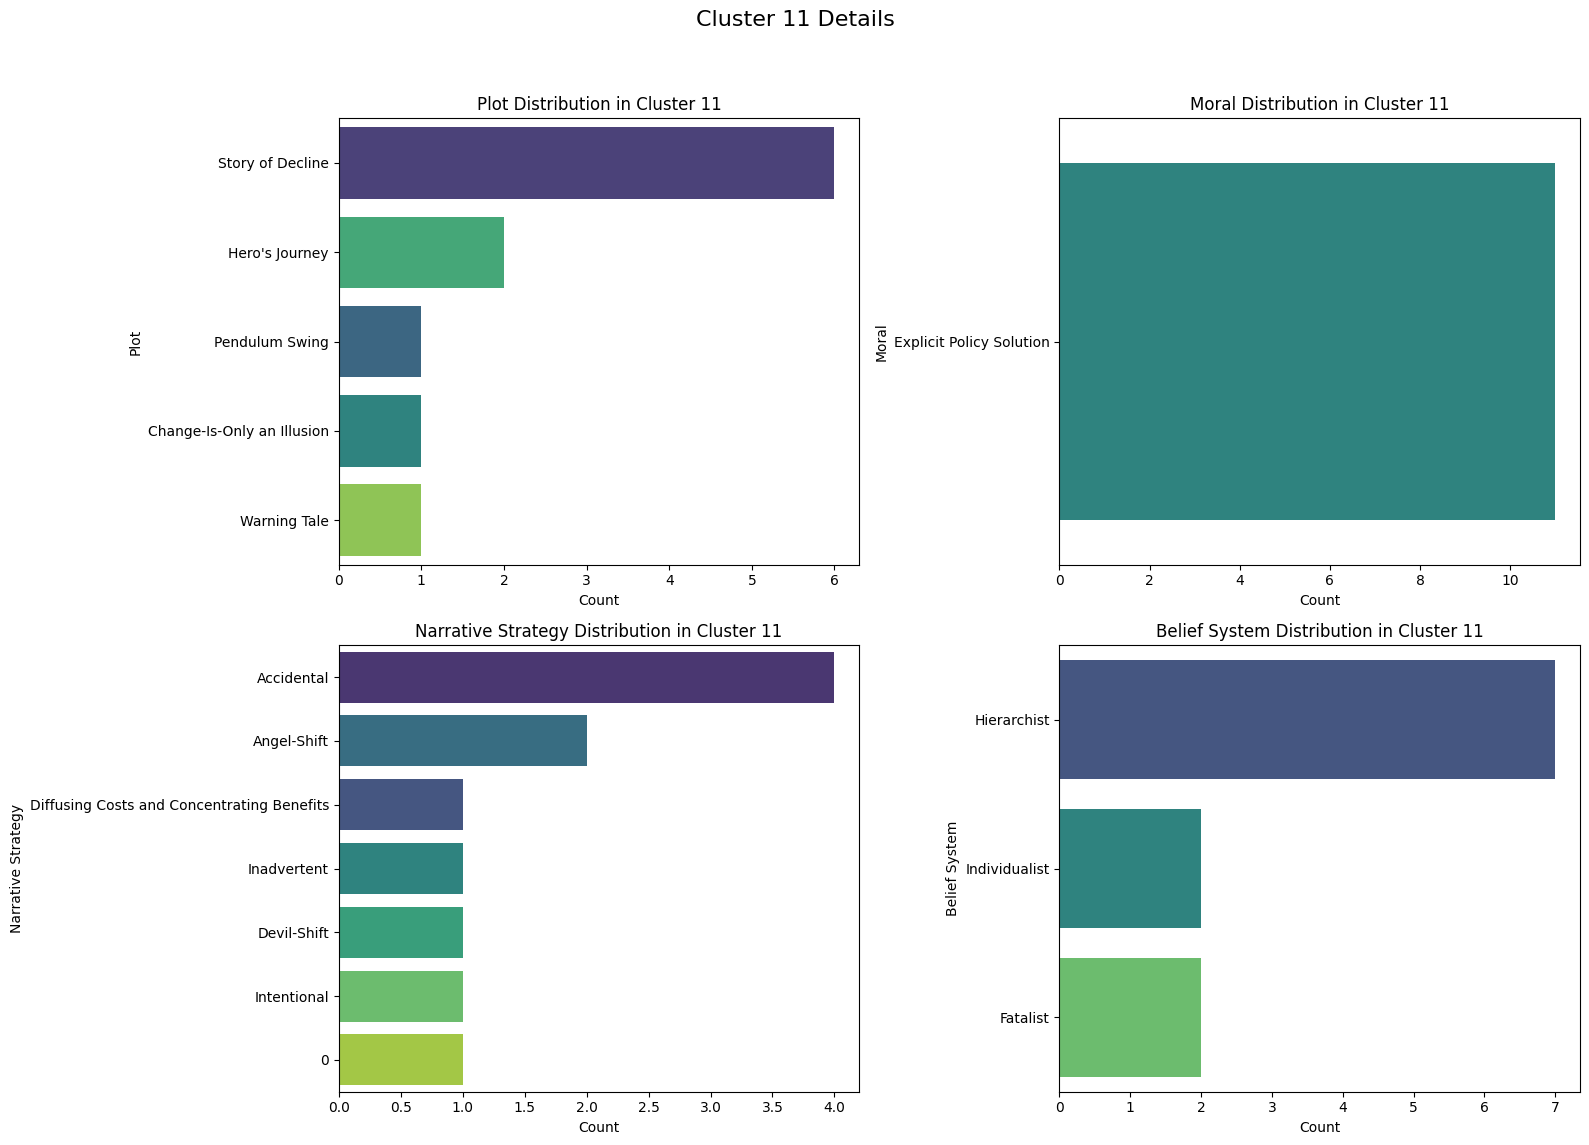

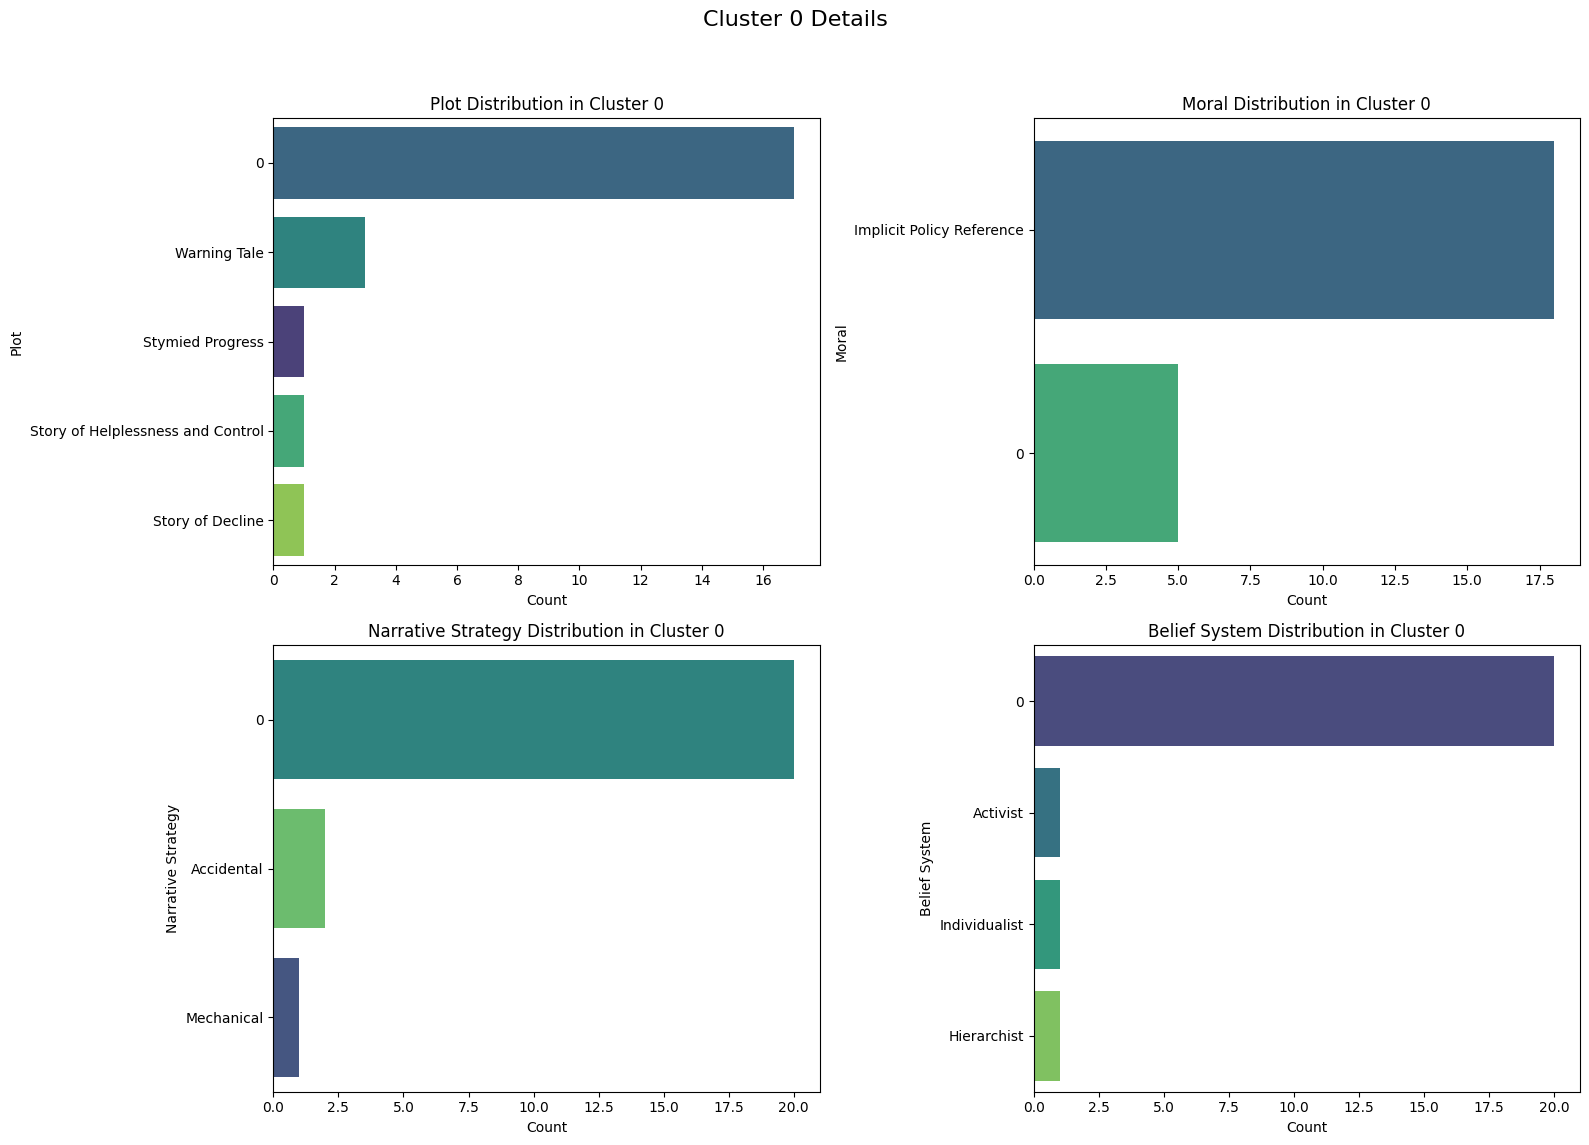

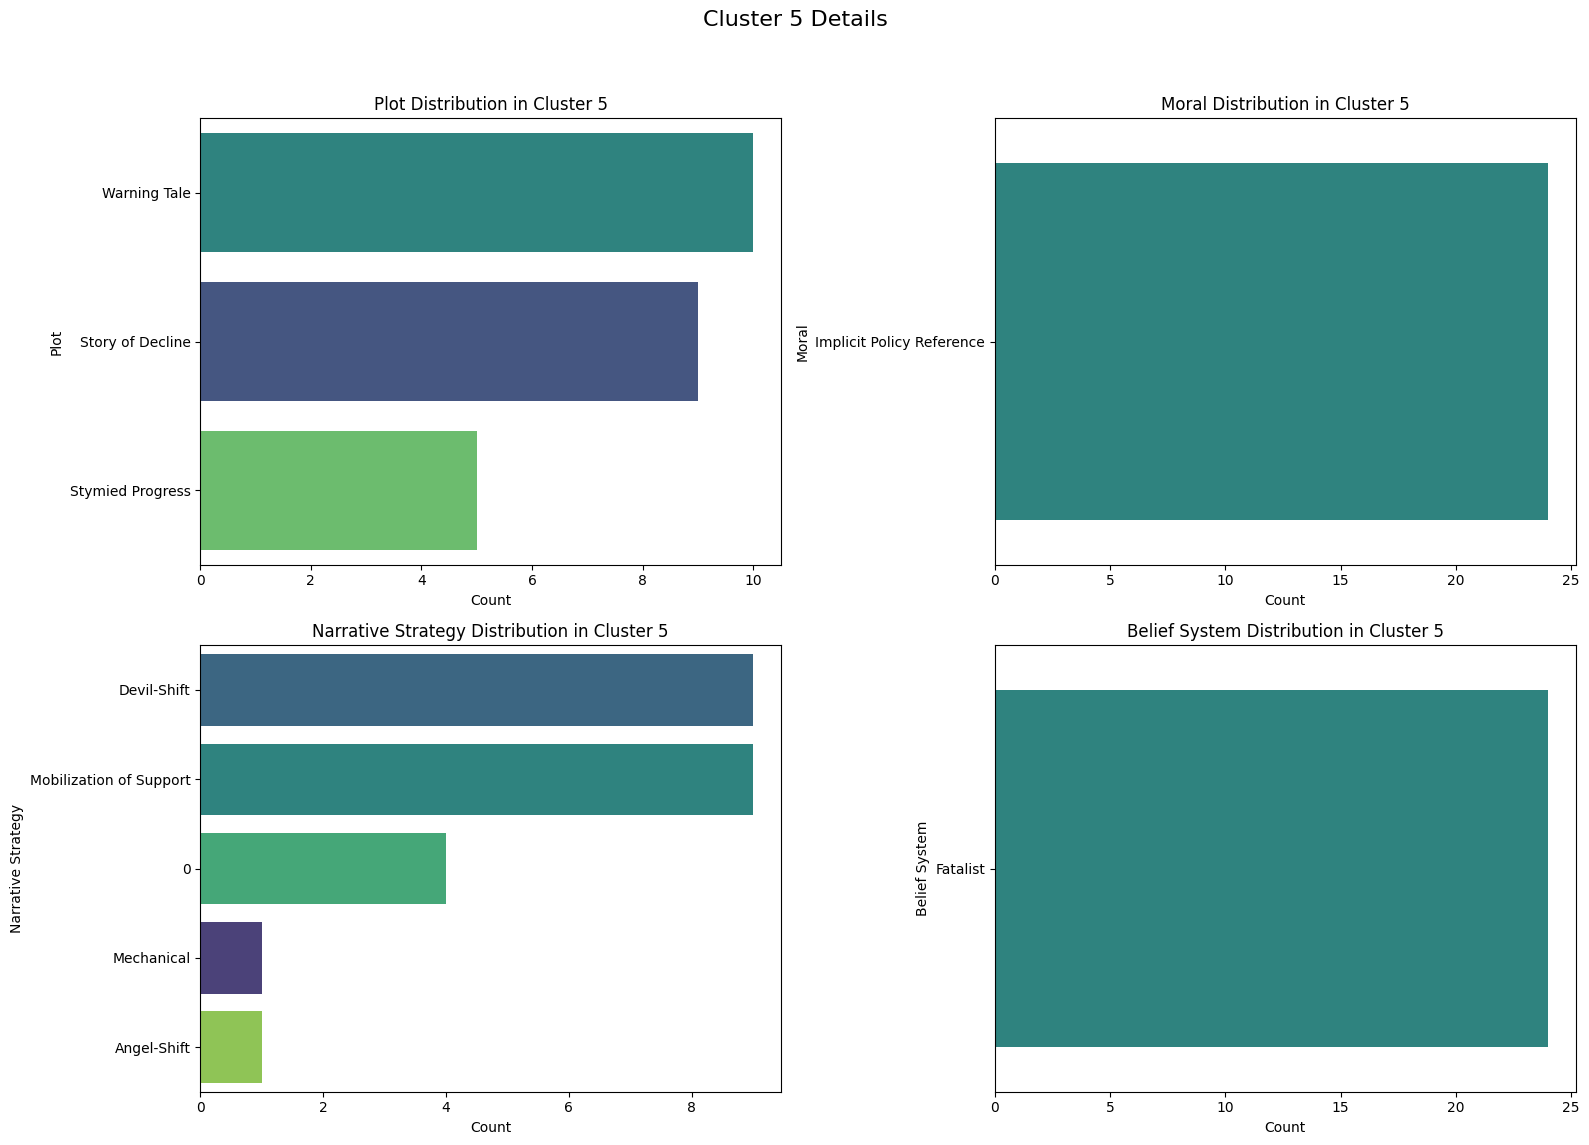

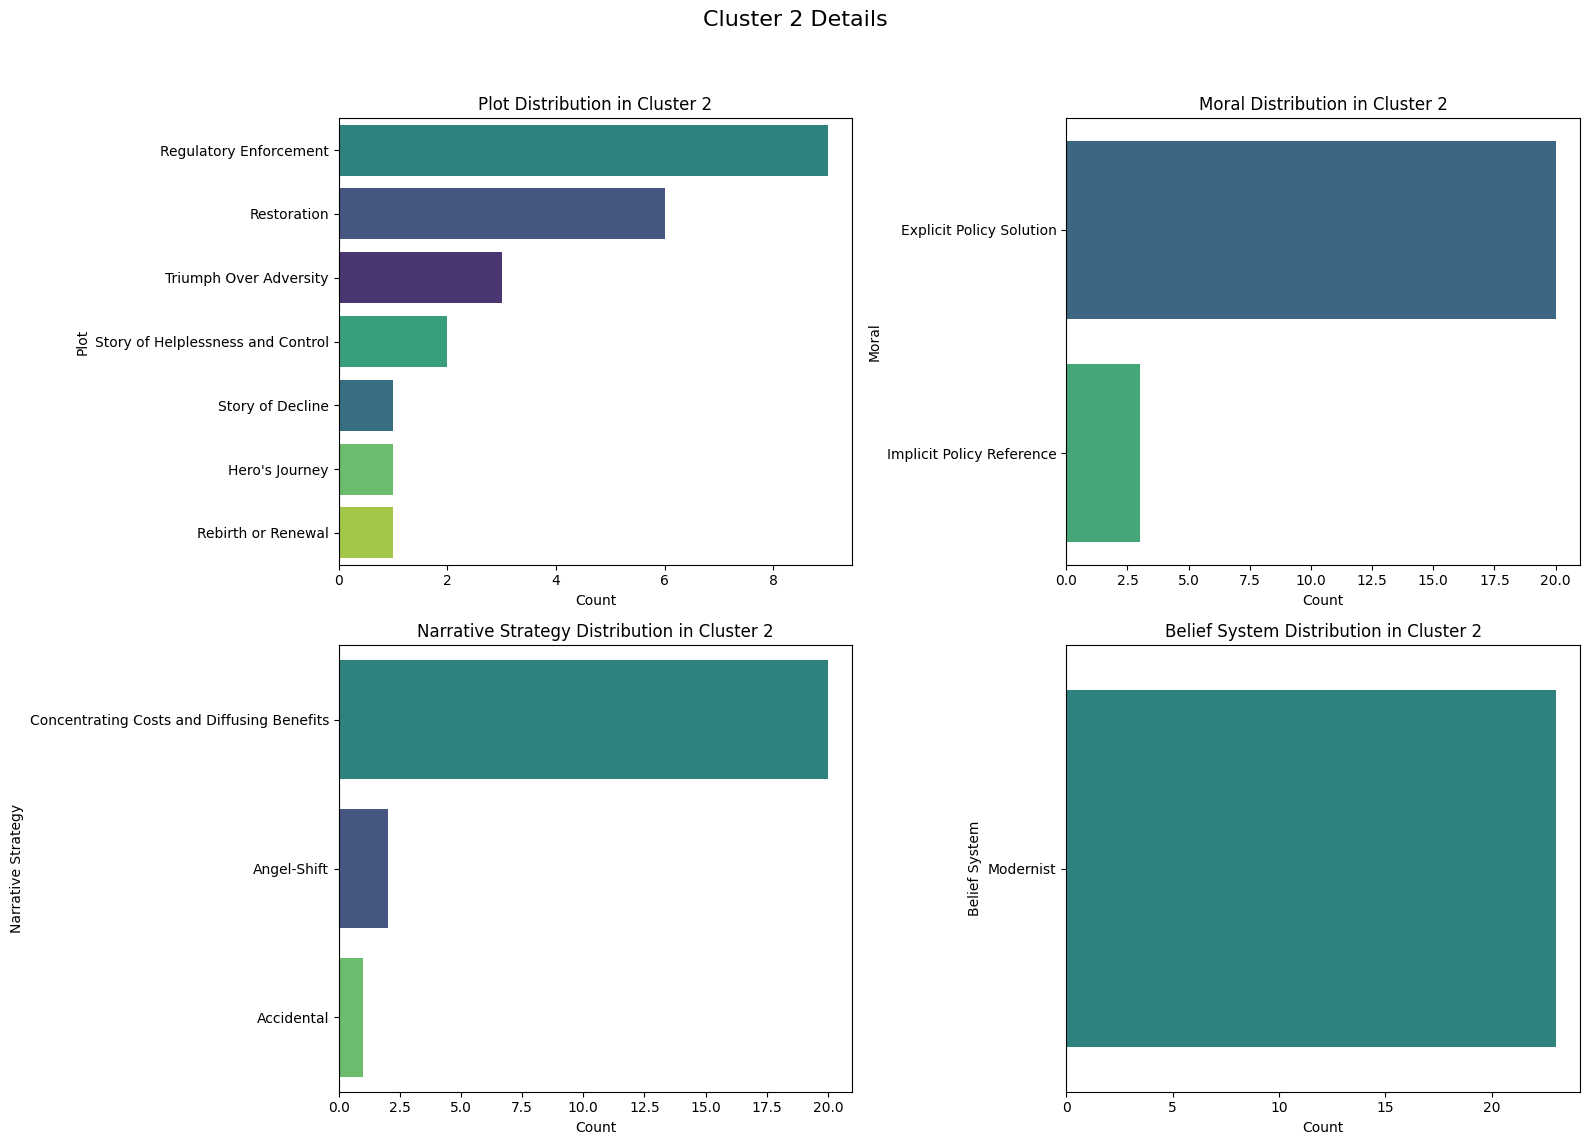

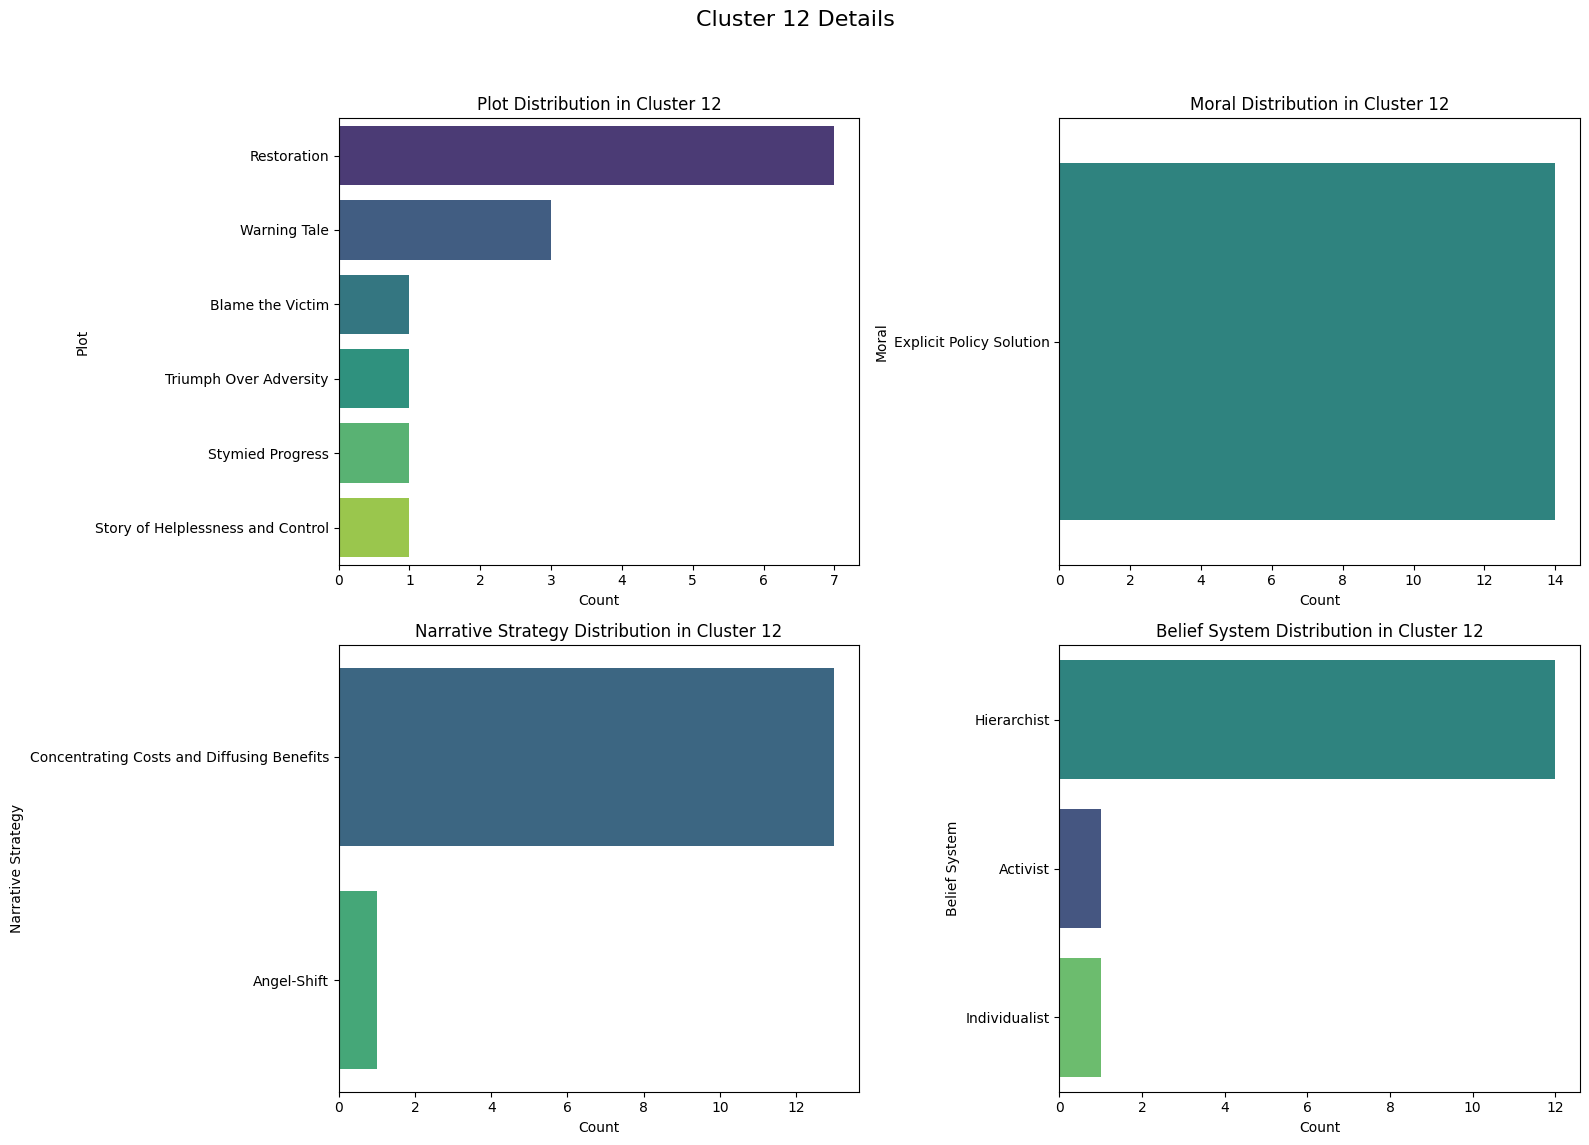

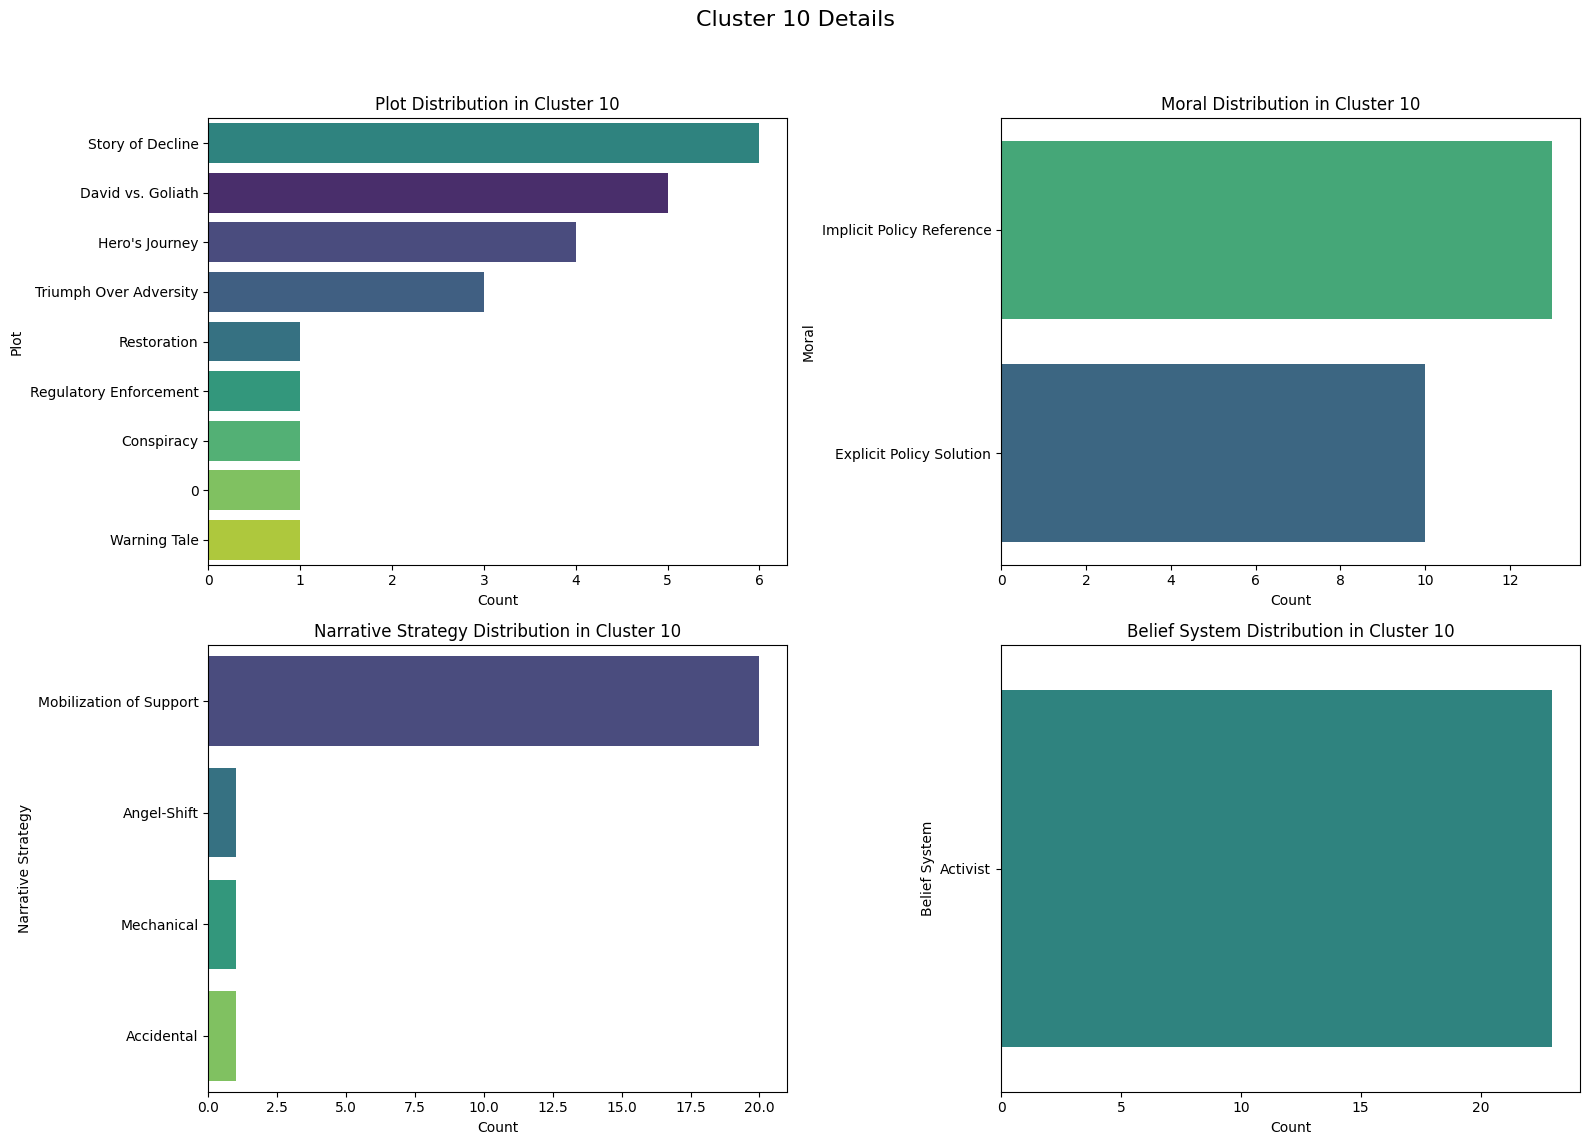

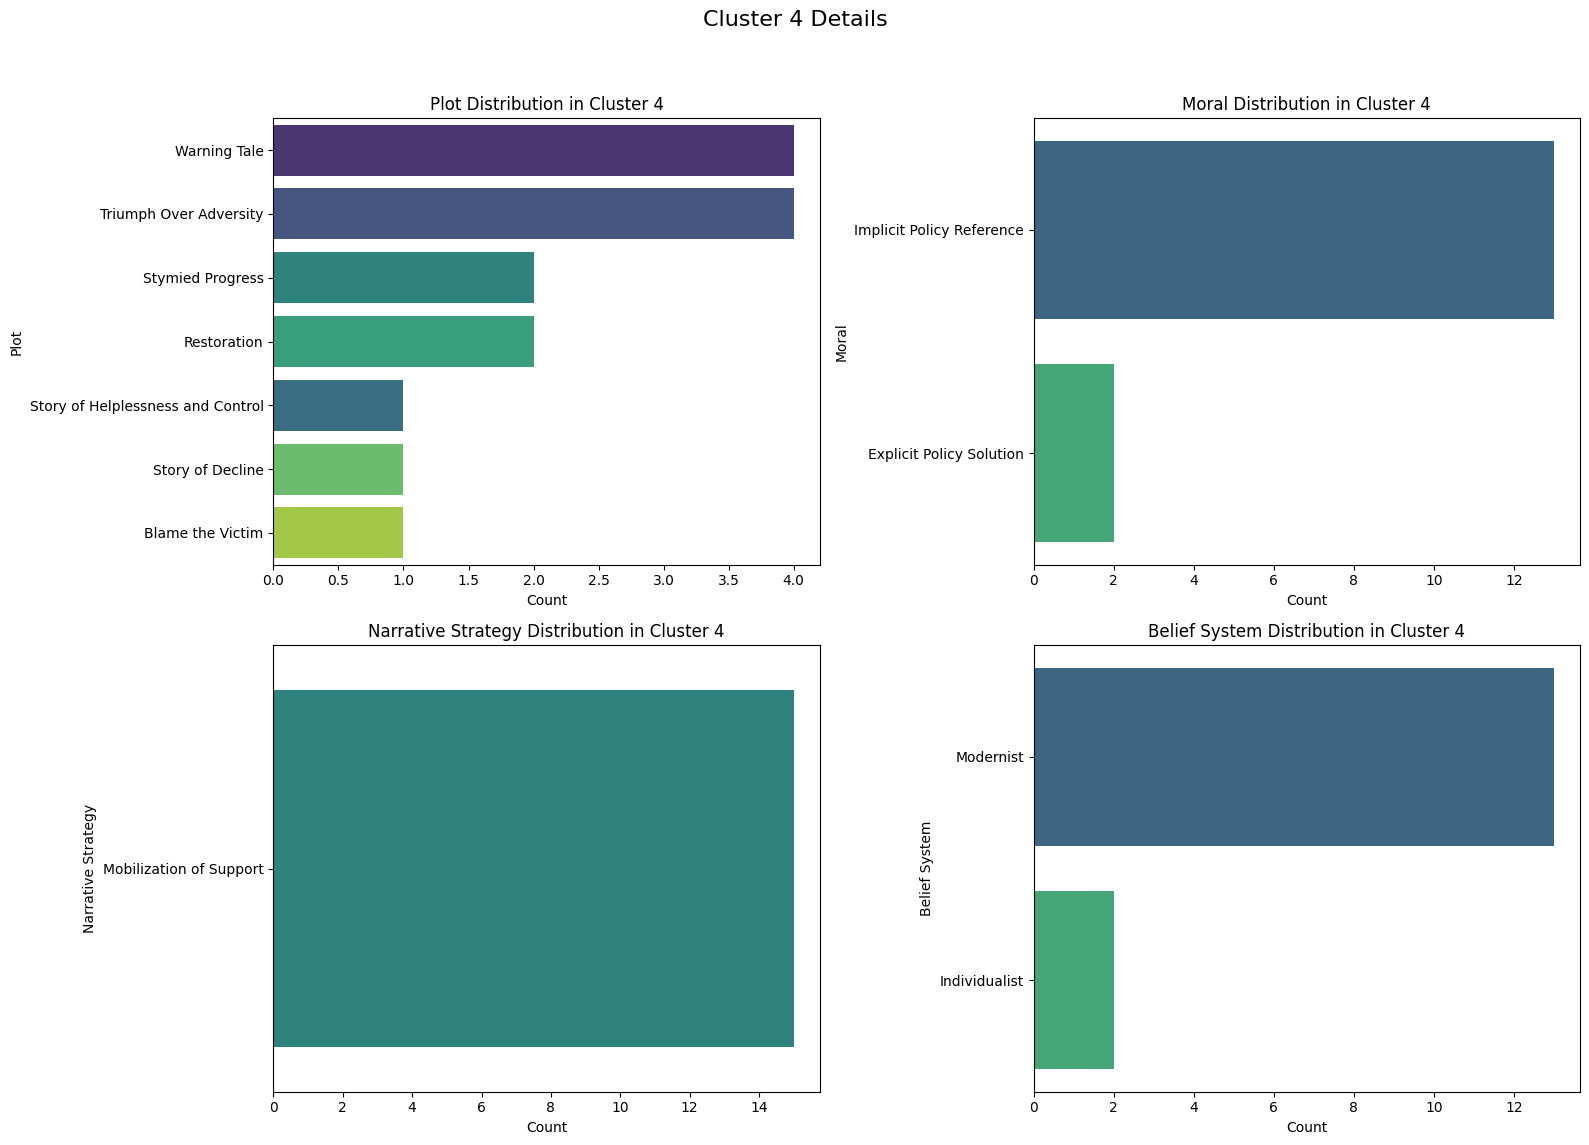

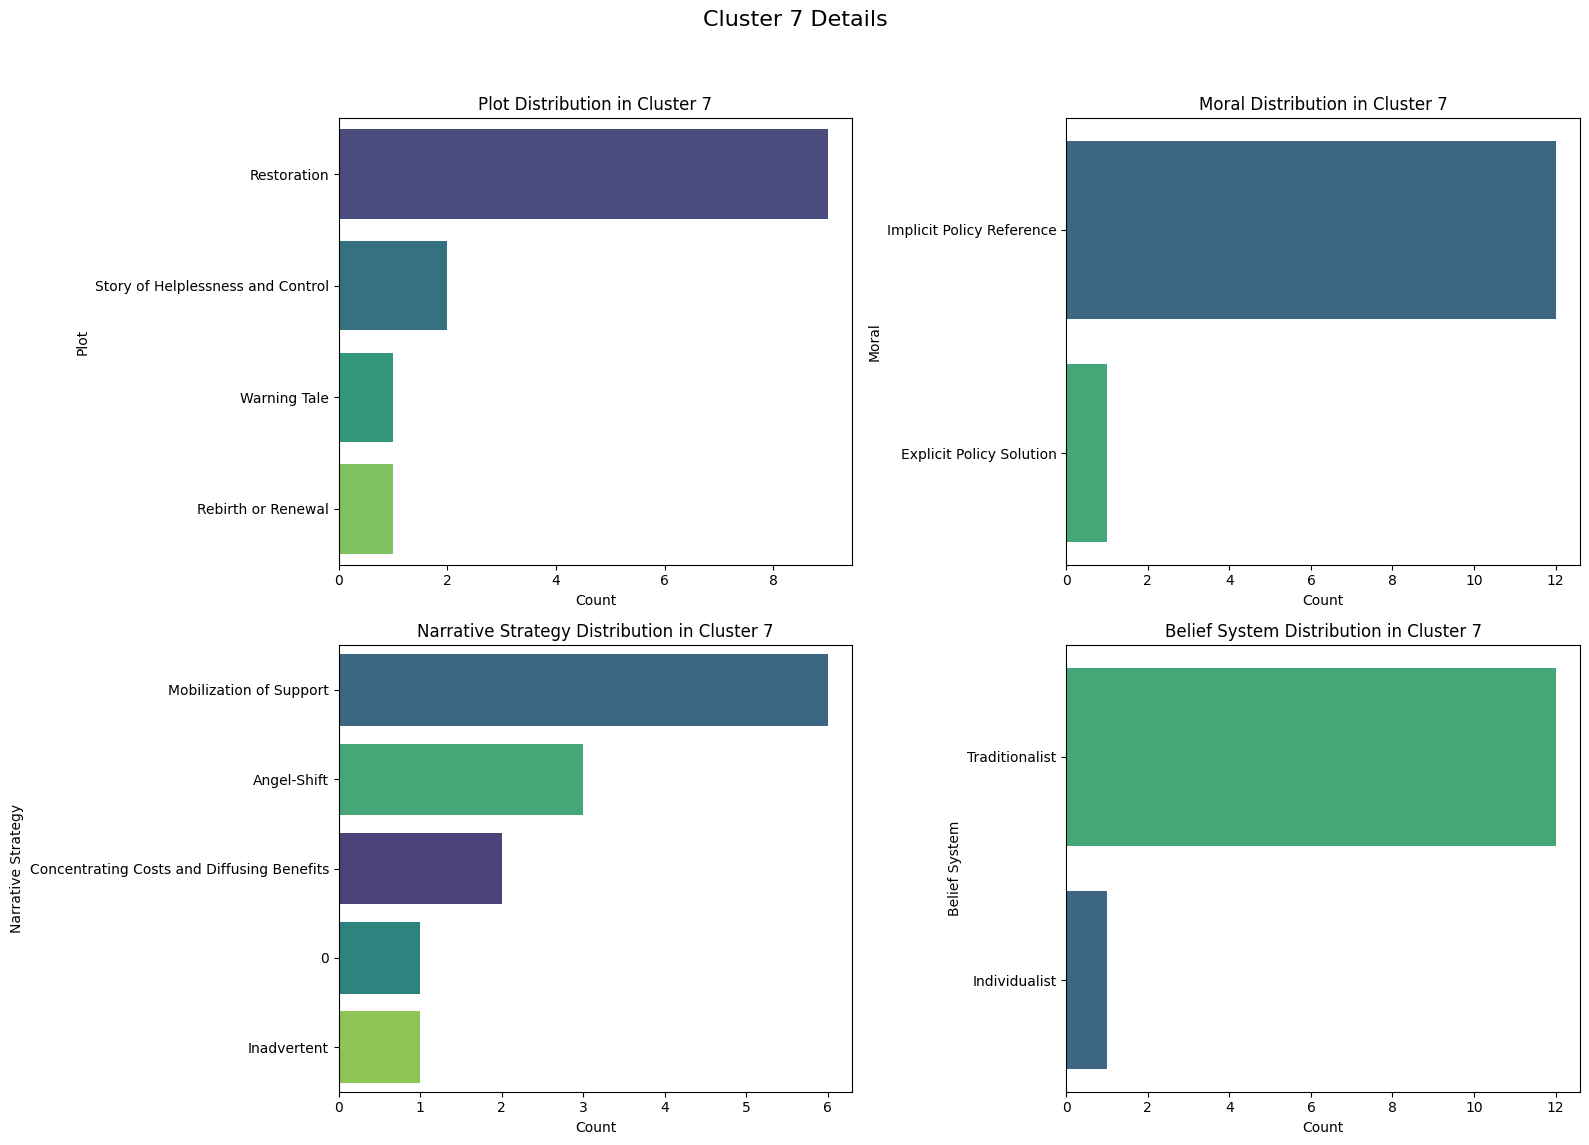

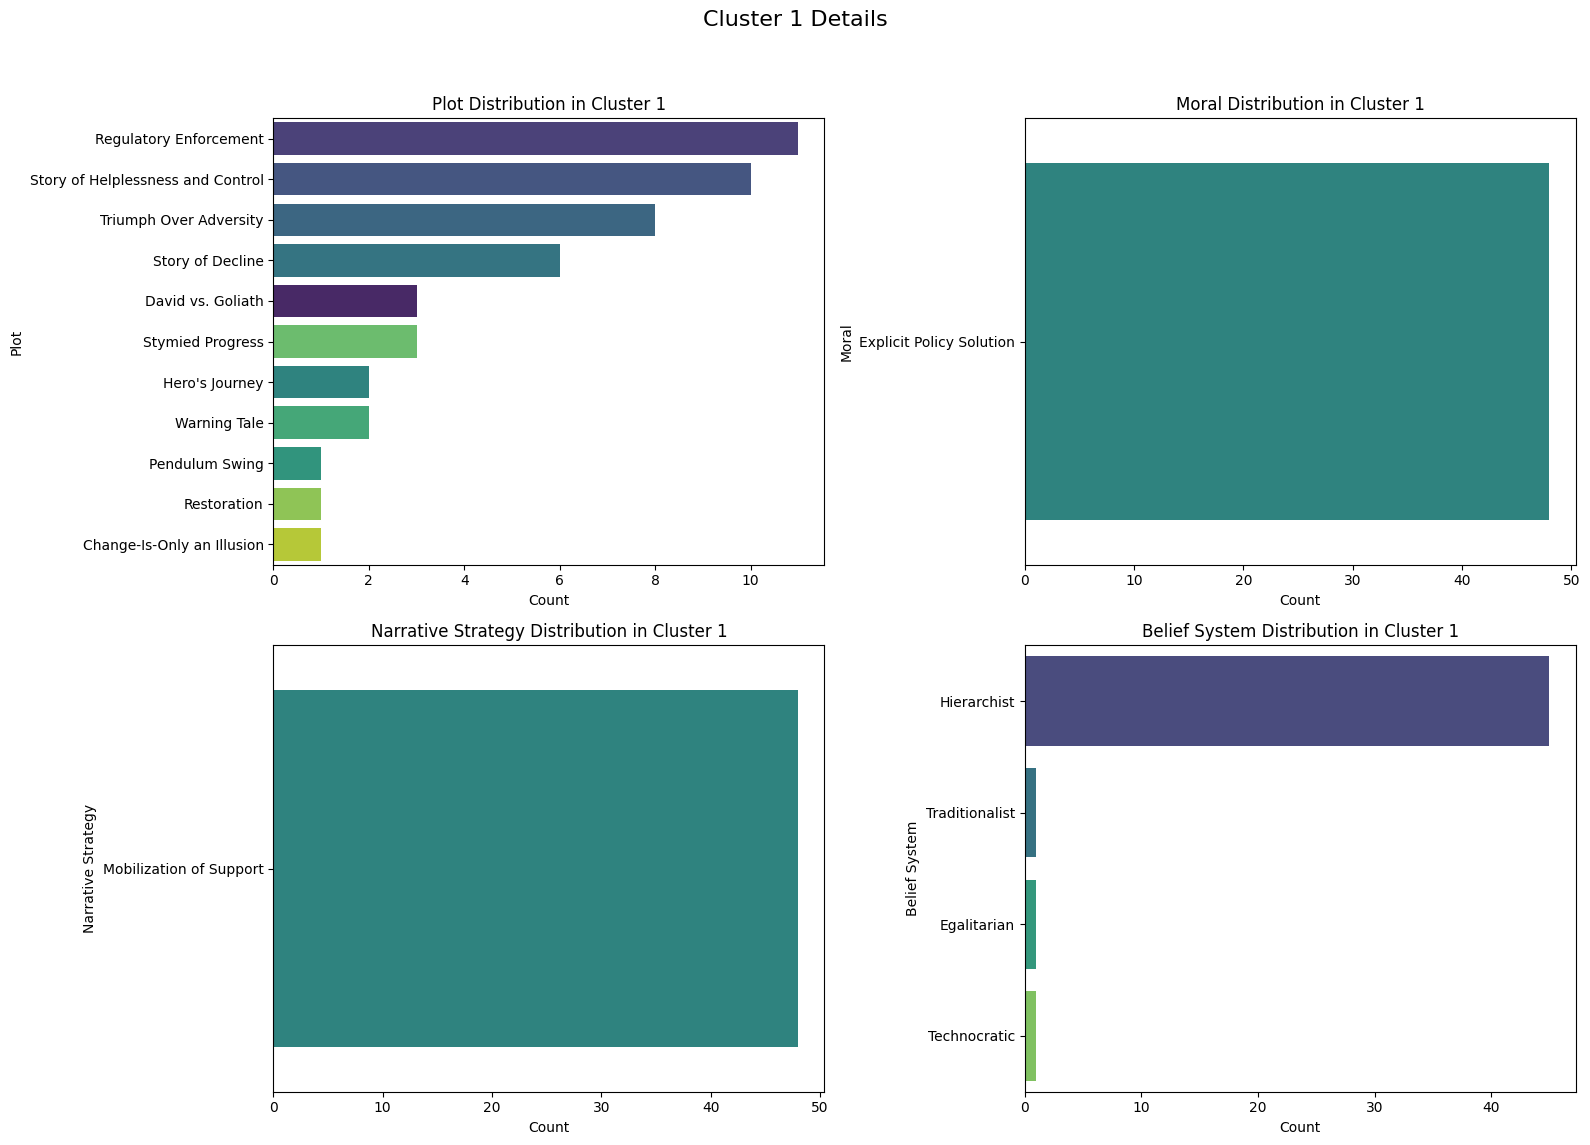

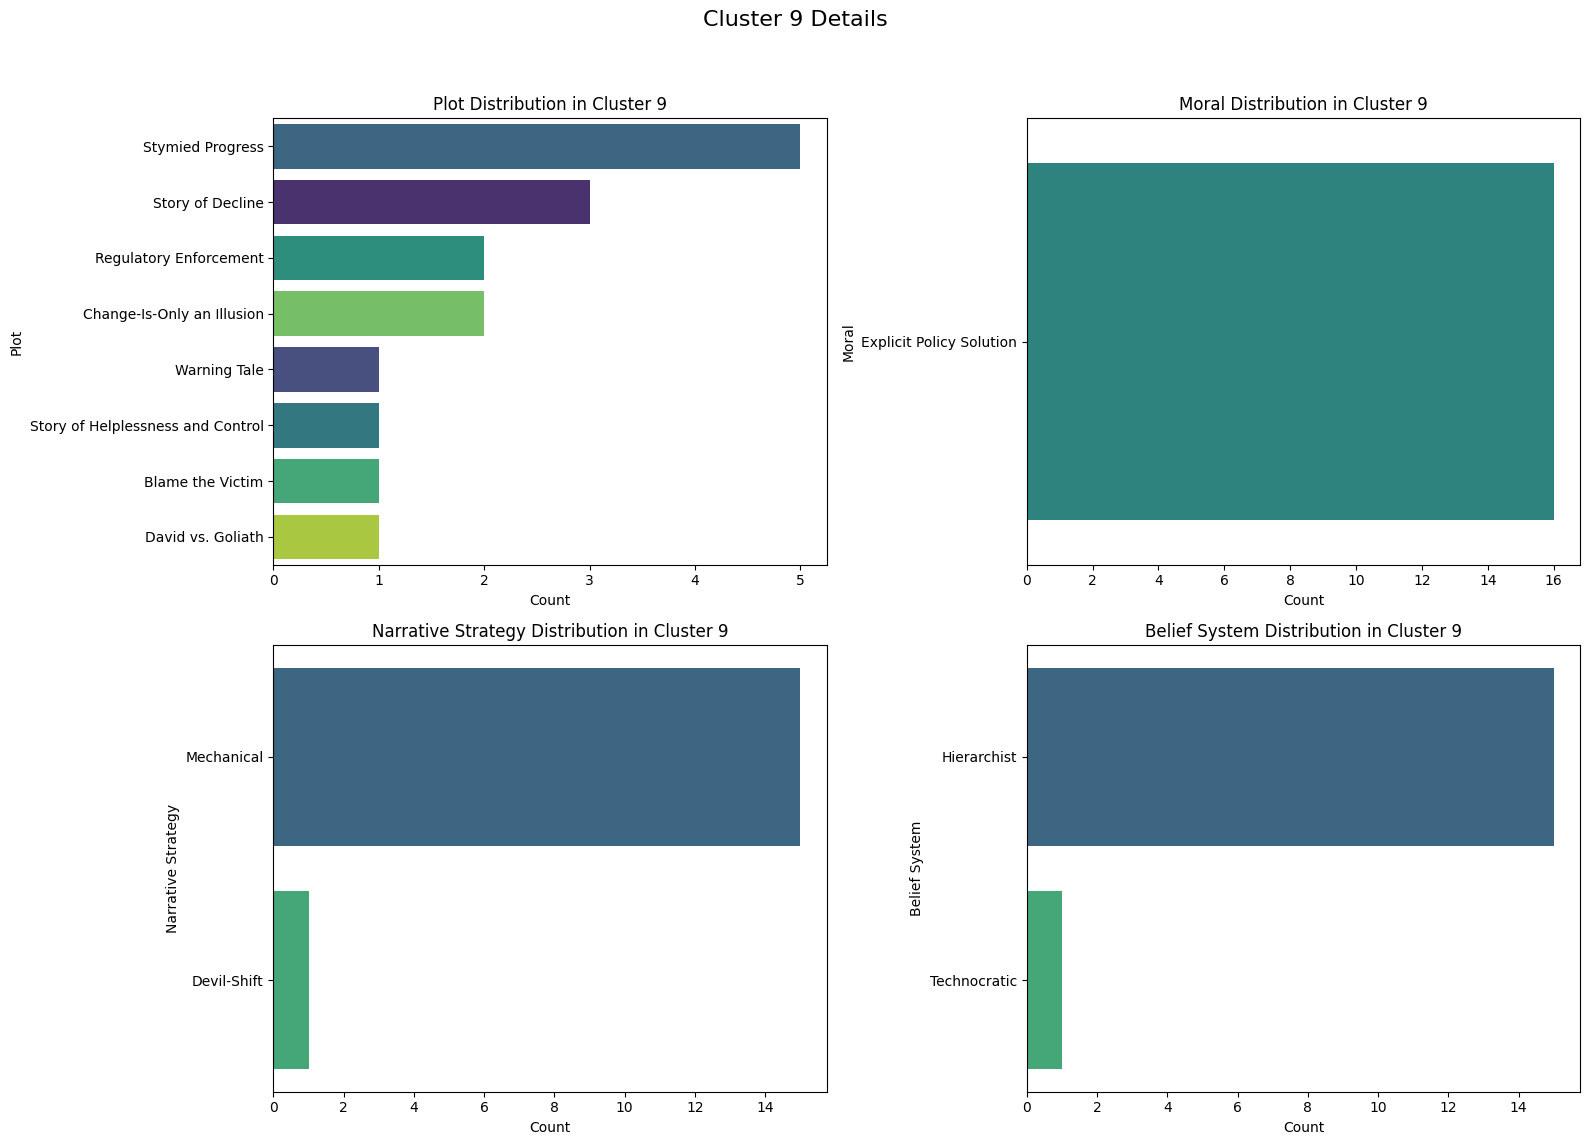

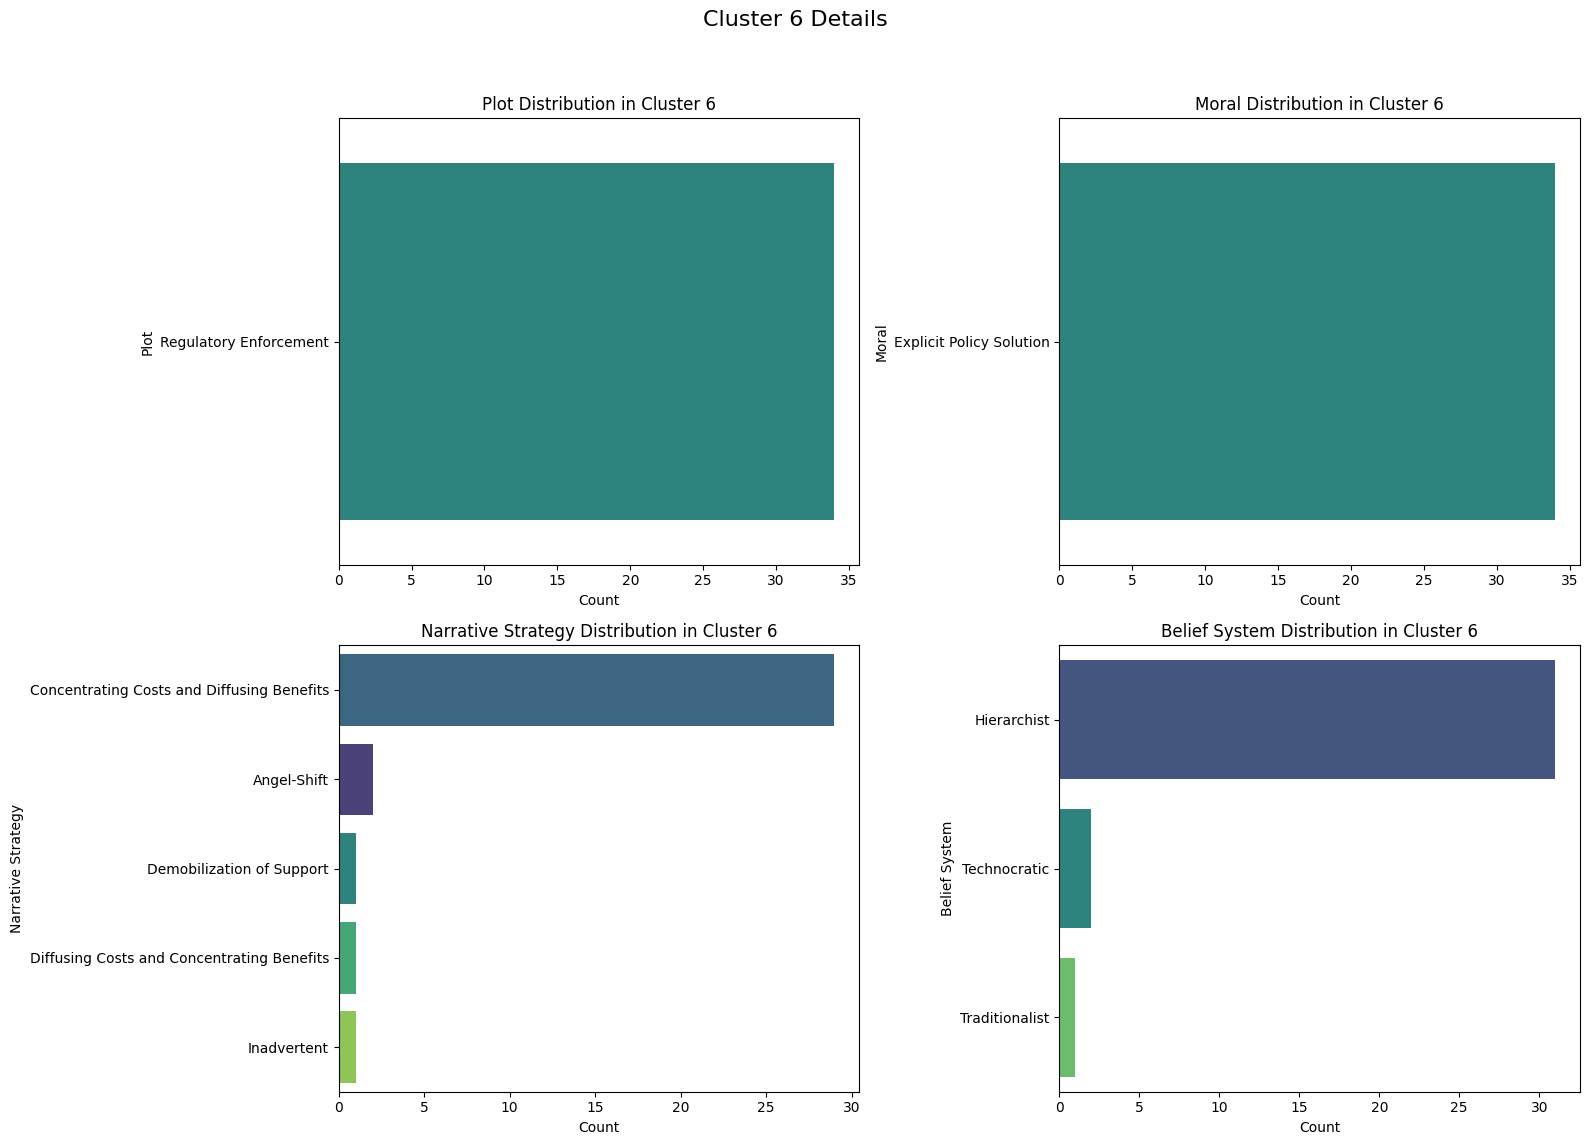

In [ ]:
# Detailed Summary: Frequency distribution for each category within each cluster
for cluster in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster]
    plt.figure(figsize=(16, 12))
    plt.suptitle(f'Cluster {cluster} Details', fontsize=16)

    for i, column in enumerate(['Plot', 'Moral', 'Narrative Strategy', 'Belief System']):
        plt.subplot(2, 2, i+1)
        sns.countplot(y=column, data=cluster_data, hue=column, legend=False, palette='viridis', order=cluster_data[column].value_counts().index)
        plt.title(f'{column} Distribution in Cluster {cluster}')
        plt.xlabel('Count')
        plt.ylabel(column)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
